In [ ]:
# -- TP 3 Ciencia de Datos
# -- Clasificación de pobres en la EPH

# -- Universidad de San Andrés - 2025
# -- Grupo 10: Francisca Cetra Oris de Roa, Mariano Ripoll y Justina Rivero Ayerza 

In [1]:
# Configuración inicial, carga de librerías y rutas para nuestro análisis.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_fscore_support)


from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# Incluimos statsmodels para tener la opción de un enfoque más estadístico
# en el modelado de Regresión Logística.
import statsmodels.api as sm

# Configuramos el estilo visual por defecto de nuestros gráficos utilizando seaborn.
# Elegimos un tema que mejora la legibilidad y la estética de las visualizaciones.
sns.set_theme(style="whitegrid")

# Definimos un nombre para la carpeta donde guardaremos las figuras que generemos
# a lo largo del análisis. Creamos esta carpeta si aún no existe para mantener
# nuestros resultados visuales organizados.
CARPETA_FIG = "Figuras_TP3"
os.makedirs(CARPETA_FIG, exist_ok=True)
print(f"Todo listo. Las figuras de nuestro análisis se guardarán en: {CARPETA_FIG}/")

DATA_DIR = "/content/"
print(f"Intentando cargar archivos desde: {os.path.abspath(DATA_DIR)}")

Todo listo. Las figuras de nuestro análisis se guardarán en: Figuras_TP3/
Intentando cargar archivos desde: /content


In [2]:
# Procesamiento Inicial de Datos

# Acá implementamos la carga, hacemos filtrado geográfico (GBA), limpieza básica
# y la creación de algunas variables clave antes de unir los datasets de 2005 y 2025.

# Definimos una función auxiliar para estandarizar los nombres de las columnas.
# Así vamos a trabajar de manera más consistente con ambos datasets.
def estandarizar_columnas(df):
    df = df.copy()
    df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]
    return df

# Realizamos una carga robusta de los datasets de 2005 (.dta) y 2025 (.xlsx o .xls).
# Incluimos manejo de errores por si los archivos no se encuentran en la ruta especificada.
try:
    df05 = pd.read_stata(os.path.join(DATA_DIR, "usu_individual_T105.dta"), convert_categoricals=False)
    path_xlsx = os.path.join(DATA_DIR, "usu_individual_T125.xlsx")
    path_xls  = os.path.join(DATA_DIR, "usu_individual_T125.xls")
    if os.path.exists(path_xlsx):
        df25 = pd.read_excel(path_xlsx)
    else:
        df25 = pd.read_excel(path_xls)
except FileNotFoundError as e:
    # Si no encontramos los archivos, levantamos un error descriptivo.
    raise FileNotFoundError(f"No pudimos abrir 2005/2025 desde {DATA_DIR}. Revisemos nombres/ruta.") from e

# Intentamos cargar la tabla de adulto equivalente si existe.
# Esta tabla es fundamental para ajustar los ingresos por composición del hogar.
tabla_ae_path = os.path.join(DATA_DIR, "tabla_adulto_equiv.xlsx")
tabla_adulto_equiv = None
if os.path.exists(tabla_ae_path):
    tabla_adulto_equiv = pd.read_excel(tabla_ae_path, header=4)
    # Limpiamos y renombramos las columnas de la tabla de adulto equivalente para mayor claridad.
    tabla_adulto_equiv = tabla_adulto_equiv.dropna(how='all').rename(columns={
        'Edad en años cumplidos': 'Edad',
        'Necesidades energéticas (kcal/día) Varones': 'Varones',
        'Mujeres': 'Mujeres'
    })

# Estandarizamos los nombres de las columnas de los datasets principales y la tabla de AE.
df05 = estandarizar_columnas(df05)
df25 = estandarizar_columnas(df25)
if tabla_adulto_equiv is not None:
    tabla_adulto_equiv = estandarizar_columnas(tabla_adulto_equiv)

# Homogeneizamos nombres de columnas clave que difieren entre los años para facilitar la unión.
rename_map_25 = {"ANO4": "YEAR", "NIVEL_EDUC": "NIVEL_ED"}
rename_map_05 = {"ANO4": "YEAR"}
df25 = df25.rename(columns=rename_map_25)
df05 = df05.rename(columns=rename_map_05)

# --- Funciones Auxiliares para Variables antes de Unir ---

# Función para normalizar la variable CH14 (último año aprobado).
# Limpiamos valores no válidos (98, 99) y fuera de rango (0-9).
def normalize_ch14(col):
    if col is None: return pd.Series(np.nan, index=df.index) # Usamos df.index asumiendo que df es global o pasado
    x = pd.to_numeric(col, errors="coerce")
    x = x.where(~x.isin([98, 99]), np.nan)
    x = x.where(x.between(0, 9), np.nan) # Mantemos el rango original de 0 a 9 como en el código original
    return x

# Función para construir la variable NIVEL_ED si no existe en el dataset.
# Mapeamos las combinaciones de CH12 (Nivel) y CH13 (Finalizó) a un código unificado de Nivel Educativo.
def construir_nivel_ed_en(df):
    df = df.copy()
    # Aseguramos que CH14_NUM exista, calculándolo si es necesario a partir de CH14.
    if "CH14" in df.columns and "CH14_NUM" not in df.columns:
        df["CH14_NUM"] = normalize_ch14(df["CH14"])
    elif "CH14_NUM" not in df.columns:
        df["CH14_NUM"] = np.nan # Si CH14 tampoco existe, llenamos con NaN

    if "NIVEL_ED" in df.columns: return df # Si NIVEL_ED ya existe, no hacemos nada.

    # Convertimos las columnas a numérico para la lógica de construcción.
    ch12 = pd.to_numeric(df.get("CH12"), errors="coerce")
    ch13 = pd.to_numeric(df.get("CH13"), errors="coerce")
    u    = pd.to_numeric(df.get("CH14_NUM"), errors="coerce")

    # Inicializamos la nueva columna con NaN y luego asignamos valores basados en la lógica.
    nivel_ed = pd.Series(np.nan, index=df.index, dtype="float")
    # La lógica de mapeo se mantiene igual que en el código original.
    nivel_ed = np.where(ch12 == 1, 1, nivel_ed)
    nivel_ed = np.where(ch12 == 9, 1, nivel_ed) # Asumimos Ns/Nr en CH12 como Primario Incompleto (1)
    nivel_ed = np.where((ch12 == 2) & (ch13 == 1), 2, nivel_ed)
    nivel_ed = np.where((ch12 == 2) & (ch13 == 2), 1, nivel_ed)
    nivel_ed = np.where((ch12 == 3) & (ch13 == 1), 3, nivel_ed)
    nivel_ed = np.where((ch12 == 3) & (ch13 == 2) & u.between(0, 6, inclusive="both"), 1, nivel_ed) # Ajuste de rango para primaria
    nivel_ed = np.where((ch12 == 3) & (ch13 == 2) & u.between(7, 9, inclusive="both"), 3, nivel_ed) # Ajuste de rango para secundaria incompleta
    nivel_ed = np.where((ch12.isin([4, 5])) & (ch13 == 1), 4, nivel_ed)
    nivel_ed = np.where((ch12.isin([4, 5])) & (ch13 == 2), 3, nivel_ed)
    nivel_ed = np.where((ch12.isin([6, 7])) & (ch13 == 1), 6, nivel_ed)
    nivel_ed = np.where((ch12.isin([6, 7])) & (ch13 == 2), 5, nivel_ed)
    nivel_ed = np.where(ch12 == 8, 6, nivel_ed) # Postgrado / Doctorado se mapea a Superior/Univ. completo (6)
    nivel_ed = np.where(ch13 == 9, 9, nivel_ed) # Ns/Nr en CH13 se mapea a 9 en NIVEL_ED
    df["NIVEL_ED"] = pd.to_numeric(nivel_ed, errors="coerce") # Convertimos a numérico al final.
    return df


# Función para filtrar las observaciones correspondientes al Gran Buenos Aires (GBA).
# Utilizamos los códigos de AGLOMERADO o REGION según el año del dataset.
def filtrar_gba(df, year_val):
    dfc = df.copy()
    dfc["YEAR"] = dfc.get("YEAR", year_val) # Aseguramos la columna YEAR
    if "AGLOMERADO" in dfc.columns:
        # Para años con AGLOMERADO, filtramos por los códigos de GBA (32, 33).
        ag = pd.to_numeric(dfc["AGLOMERADO"], errors="coerce")
        return dfc[ag.isin([32, 33])].copy()
    elif "REGION" in dfc.columns:
        # Para años con REGION, filtramos por el código de GBA (1).
        return dfc[dfc["REGION"].astype(str).str.strip().str.lstrip("0") == "1"].copy()
    else:
        # Si no encontramos columna de localización, devolvemos el dataframe completo (con advertencia).
        print("Advertencia: No se encontró columna 'AGLOMERADO' ni 'REGION' para filtrar GBA.")
        return dfc

# Aplicamos la función de filtrado a ambos datasets.
df05_gba = filtrar_gba(df05, 2005)
df25_gba = filtrar_gba(df25, 2025)

# Construimos la variable NIVEL_ED en ambos datasets filtrados si aún no existe.
df05_gba = construir_nivel_ed_en(df05_gba)
df25_gba = construir_nivel_ed_en(df25_gba)


# Definimos la lista de columnas necesarias para nuestro análisis posterior.
# Incluimos identificadores, variables de ingresos, demográficas, educativas y laborales.
cols_necesarias = [
    "YEAR", "CODUSU", "NRO_HOGAR", "AGLOMERADO", "ITF", "IPCF", "CH06", "CH04", "CH03",
    "CH12", "CH13", "CH14", "CH14_NUM", "NIVEL_ED", "CAT_OCUP", "TOT_P12",
    "CH07", "ESTADO", "PP3E_TOT", "CH08"
]

# Homogeneizamos el nombre de la columna de número de hogar si es necesario.
if "NRO_HOGAR" not in df05_gba.columns and "NRO_HOG" in df05_gba.columns:
    df05_gba = df05_gba.rename(columns={"NRO_HOG": "NRO_HOGAR"})
if "NRO_HOGAR" not in df25_gba.columns and "NRO_HOG" in df25_gba.columns:
    df25_gba = df25_gba.rename(columns={"NRO_HOG": "NRO_HOGAR"})


# Identificamos las columnas que existen en ambos datasets filtrados y que son necesarias.
common_cols_05 = set(df05_gba.columns) & set(cols_necesarias)
common_cols_25 = set(df25_gba.columns) & set(cols_necesarias)
final_common_cols = sorted(list(common_cols_05 & common_cols_25))

# Verificamos si hay columnas comunes suficientes para continuar.
if not final_common_cols:
    raise RuntimeError("No hay columnas comunes suficientes entre 2005 y 2025 para continuar. Revisemos las columnas necesarias y los archivos de datos.")

# Unimos los datasets de 2005 y 2025 usando solo las columnas comunes y necesarias.
# Ignoramos los índices originales para crear un nuevo índice continuo.
df_unida = pd.concat([df05_gba[final_common_cols], df25_gba[final_common_cols]], ignore_index=True)

# Convertimos columnas numéricas a tipo numérico, tratando errores como NaN.
num_cols = [
    "YEAR", "ITF", "IPCF", "CH06", "CH04", "CH03", "CH12", "CH13", "CH14", "CH14_NUM",
    "TOT_P12", "CAT_OCUP", "NIVEL_ED", "AGLOMERADO", "CH07", "ESTADO", "PP3E_TOT", "CH08"
]
for col in num_cols:
    if col in df_unida.columns:
        df_unida[col] = pd.to_numeric(df_unida[col], errors="coerce")

# Limpiamos valores atípicos en las columnas de ingresos y edad.
df_unida.loc[df_unida["ITF"]  < 0, "ITF"]  = np.nan
df_unida.loc[df_unida["IPCF"] < 0, "IPCF"] = np.nan
df_unida.loc[(df_unida["CH06"] < 0) | (df_unida["CH06"] > 100), "CH06"] = np.nan

# INICIO: LIMPIEZA ADICIONAL Y CREACIÓN DE NUEVAS VARIABLES

# --- CH07 – Estado Civil (Variable Categórica) ---
# Mapeamos los códigos numéricos del Estado Civil a categorías descriptivas.
# Esto mejora la interpretabilidad de la variable.
if 'CH07' in df_unida.columns:
    ch07_map = {
        1: 'Unido',
        2: 'Casado',
        3: 'Separado_Divorciado',
        4: 'Viudo',
        5: 'Soltero'
    }
    df_unida['CH07'] = df_unida['CH07'].map(ch07_map).astype('category')

# 2. ESTADO – Condición de actividad laboral
# Eliminamos los casos con ESTADO 0 (no especificado) y mapeamos los códigos a categorías.
if 'ESTADO' in df_unida.columns:
    df_unida = df_unida[df_unida['ESTADO'] != 0]
    estado_map = {1: 'Ocupado', 2: 'Desocupado', 3: 'Inactivo', 4: 'Menor10'}
    df_unida['ESTADO'] = df_unida['ESTADO'].replace(estado_map).astype('category')

# 3. PP3E_TOT – Horas totales trabajadas
# Limpiamos y tratamos las horas trabajadas, imputando 0 a los no ocupados
# y limitando el valor máximo a un umbral razonable.
if 'PP3E_TOT' in df_unida.columns:
    df_unida['PP3E_TOT'] = pd.to_numeric(df_unida['PP3E_TOT'], errors='coerce')
    mask_not_working = df_unida['ESTADO'] != 'Ocupado'
    df_unida.loc[mask_not_working, 'PP3E_TOT'] = 0 # Asignamos 0 horas a quienes no están ocupados
    df_unida['PP3E_TOT'] = df_unida['PP3E_TOT'].fillna(0) # Imputamos 0 a NaNs restantes
    horas_max = 84 # Definimos un límite máximo razonable de horas
    df_unida.loc[df_unida['PP3E_TOT'] > horas_max, 'PP3E_TOT'] = horas_max

# 4. adulto_equiv y ad_equiv_hogar
# Calculamos el adulto equivalente individual y del hogar, fundamental para el cálculo de la pobreza.
adulto_equiv_disponible = False
if tabla_adulto_equiv is not None:
    # Intentamos realizar el merge con la tabla de adulto equivalente si está disponible.
    cols = {c: c for c in tabla_adulto_equiv.columns}
    edad_col  = [c for c in cols if "EDAD" in c.upper()]
    varon_col = [c for c in cols if "VAR"  in c.upper()]
    mujer_col = [c for c in cols if "MUJ"  in c.upper()]
    if edad_col and varon_col and mujer_col:
        t = tabla_adulto_equiv[[edad_col[0], varon_col[0], mujer_col[0]]].copy()
        t.columns = ["EDAD", "CONSUMO_VARON", "CONSUMO_MUJER"]
        t["EDAD"] = pd.to_numeric(t["EDAD"], errors="coerce").round()
        t = t.dropna(subset=["EDAD"]).drop_duplicates(subset=["EDAD"])
        # Realizamos el merge para traer los factores de consumo según edad.
        df_unida['CH06_rounded'] = df_unida['CH06'].round() # Redondeamos edad para el merge
        df_unida = df_unida.merge(t, left_on="CH06_rounded", right_on="EDAD", how="left")
        # Calculamos el AE individual basado en el sexo (CH04).
        df_unida["adulto_equiv"] = np.where(df_unida["CH04"] == 1, df_unida["CONSUMO_VARON"], df_unida["CONSUMO_MUJER"])
        # Eliminamos columnas temporales usadas para el merge.
        df_unida.drop(columns=['EDAD','CONSUMO_VARON','CONSUMO_MUJER','CH06_rounded'], inplace=True, errors='ignore')
        adulto_equiv_disponible = True # Indicamos que el cálculo fue exitoso.

# Si la tabla de AE no estaba disponible o falló el merge, imputamos 1.0 como AE individual.
if not adulto_equiv_disponible or 'adulto_equiv' not in df_unida.columns:
    df_unida["adulto_equiv"] = 1.0
df_unida['adulto_equiv'] = df_unida['adulto_equiv'].fillna(1.0) # Aseguramos que no haya NaNs en AE individual

# Calculamos el AE del hogar sumando los AE individuales dentro de cada hogar.
hog_keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
df_unida["ad_equiv_hogar"] = df_unida.groupby(hog_keys)["adulto_equiv"].transform("sum")

# 5. RAZON DE MENORES
# Calculamos la proporción de menores de 18 años respecto a los adultos en cada hogar.
if 'CH06' in df_unida.columns:
    df_unida['es_menor'] = (df_unida['CH06'] < 18).astype(int)
    df_unida['es_adulto'] = (df_unida['CH06'] >= 18).astype(int)
    # Agrupamos por hogar para contar menores y adultos.
    razon_df = df_unida.groupby(hog_keys).agg(menores=('es_menor', 'sum'), adultos=('es_adulto', 'sum')).reset_index()
    # Calculamos la razón, manejando el caso de hogares sin adultos para evitar división por cero.
    razon_df['razon_menores'] = razon_df.apply(lambda row: row['menores'] / row['adultos'] if row['adultos'] > 0 else row['menores'], axis=1)
    # Mergeamos la razón de menores de vuelta al dataframe principal.
    df_unida = df_unida.merge(razon_df[hog_keys + ['razon_menores']], on=hog_keys, how='left')
    # Eliminamos columnas temporales.
    df_unida.drop(columns=['es_menor', 'es_adulto'], inplace=True)

# Si TOT_P12 (Total de personas en el hogar) no está disponible o tiene solo NaNs, lo calculamos.
# Agrupamos por hogar y contamos el número de individuos.
if "TOT_P12" not in df_unida.columns or df_unida["TOT_P12"].isna().all():
    keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
    df_unida["TOT_P12"] = df_unida.groupby(keys)["CODUSU"].transform("size")

# Imprimimos las dimensiones del dataframe unido y limpio.
print(f"Base unida y limpia. Dimensiones: {df_unida.shape}")
# Mostramos las primeras filas con algunas de las columnas procesadas para verificación.
display(df_unida[["YEAR", "NIVEL_ED", "CH07", "ESTADO", "PP3E_TOT", "ad_equiv_hogar", "razon_menores"]].head())

Base unida y limpia. Dimensiones: (16614, 23)


,YEAR,NIVEL_ED,CH07,ESTADO,PP3E_TOT,ad_equiv_hogar,razon_menores
0,2005.0,3.0,Viudo,Inactivo,0.0,1.0,0.0
1,2005.0,4.0,Casado,Ocupado,20.0,3.0,0.0
2,2005.0,6.0,Casado,Inactivo,0.0,3.0,0.0
3,2005.0,7.0,Soltero,Menor10,0.0,3.0,0.0
4,2005.0,2.0,Viudo,Inactivo,0.0,1.0,0.0


In [3]:
# Creación de nuevas variables derivadas a nivel individual y de hogar.

# En esta celda, nos enfocamos en generar variables adicionales que consideramos
# relevantes para predecir la pobreza a nivel individual y del hogar.

# 1) Creación de 'educ' y 'edad2'
# La variable 'educ' estima los años de educación formal de cada individuo.
# La variable 'edad2' es la edad al cuadrado, para capturar efectos no lineales de la edad.
def educ_desde_nivel(df, col_nivel="NIVEL_ED", col_ch13="CH13", col_ch14num="CH14_NUM", univ_completo_anios=16):
    # Esta función calcula una estimación de años de educación a partir de las variables de la EPH.
    # Consideramos el nivel educativo alcanzado, si el nivel fue finalizado, y el último año aprobado.
    n = len(df)
    s = np.full(n, np.nan, dtype="float64")
    nivel = pd.to_numeric(df.get(col_nivel), errors="coerce").to_numpy()
    ch13  = pd.to_numeric(df.get(col_ch13),  errors="coerce").to_numpy()
    u     = pd.to_numeric(df.get(col_ch14num), errors="coerce").to_numpy()
    usa_u = (ch13 == 2) # Usamos el último año aprobado si el nivel no fue finalizado

    # Asignamos años de educación según el nivel y si fue finalizado.
    m = (nivel == 7); s = np.where(m, 0, s) # Sin instrucción: 0 años
    m = (nivel == 1); cond_u_prim = usa_u & (u >= 0) & (u <= 6); s = np.where(m & cond_u_prim, u, s); s = np.where(m & ~cond_u_prim, 1, s) # Primario incompleto
    m = (nivel == 2); s = np.where(m, 7, s) # Primario completo: 7 años
    m = (nivel == 3); cond_u_sec = usa_u & (u >= 1) & (u <= 5); s = np.where(m & cond_u_sec, 7 + np.clip(u, 1, 5), s); s = np.where(m & ~cond_u_sec, 8, s) # Secundario incompleto
    m = (nivel == 4); s = np.where(m, 12, s) # Secundario completo: 12 años
    m = (nivel == 5); cond_u_sup = usa_u & (u >= 1) & (u <= 4); s = np.where(m & cond_u_sup, 12 + np.clip(u, 1, 4), s); s = np.where(m & ~cond_u_sup, 13, s) # Superior/Univ incompleto
    m = (nivel == 6); s = np.where(m, float(univ_completo_anios), s) # Superior/Univ completo: 16 años (por defecto)
    # Filtramos valores que no caen dentro de un rango razonable (0-25 años)
    s = pd.Series(s, index=df.index, dtype="float64").where((s >= 0) & (s <= 25))
    return s.rename("educ")

# Aplicamos la función para crear 'educ' y calculamos 'edad2'.
df_unida["educ"] = educ_desde_nivel(df_unida)
df_unida["edad2"] = df_unida["CH06"] ** 2

# 2) Tratamiento de CH08 (Cobertura Médica) a Categórica
# Mapeamos los códigos numéricos de la cobertura médica a categorías descriptivas.
# Esto nos permite usar esta información como una variable categórica en los modelos.
if 'CH08' in df_unida.columns:
    ch08_map = {
        1: 'Obra_Social', 2: 'Prepaga_Mutual', 3: 'Publico', 4: 'No_Paga', 9: 'NsNr',
        12: 'Combinada', 13: 'Combinada', 23: 'Combinada', 123: 'Combinada'
    }
    df_unida['COBERTURA_MEDICA'] = df_unida['CH08'].map(ch08_map).astype('category')

# 3) Definición de claves de hogar
# Definimos una lista de columnas que identifican de forma única a cada hogar.
# Esto es necesario para agrupar y calcular variables a nivel de hogar.
hog_keys = ["YEAR", "CODUSU", "NRO_HOGAR"]

# 4) Creación de ratios de hogar
# Calculamos ratios que describen la composición y la situación laboral del hogar.
# Estos ratios pueden ser predictores importantes de la pobreza.
tmp = df_unida[hog_keys + ["CH06", "ESTADO"]].copy()
tmp["es_menor"]     = (tmp["CH06"] < 15).astype(int)    # Indicador de menor de 15 años
tmp["es_mayor"]     = (tmp["CH06"] >= 65).astype(int)   # Indicador de mayor de 65 años
tmp["es_ocupado"]   = (tmp["ESTADO"] == 'Ocupado').astype(int) # Indicador de persona ocupada
agg = (tmp
       .groupby(hog_keys, observed=False)
       .agg(n_miembros = ("CH06", "count"), # Número total de miembros en el hogar
            n_menores  = ("es_menor", "sum"), # Número de menores en el hogar
            n_mayores  = ("es_mayor", "sum"), # Número de mayores en el hogar
            n_ocupados = ("es_ocupado", "sum")) # Número de ocupados en el hogar
       .reset_index())
agg["n_dependientes"]      = agg["n_menores"] + agg["n_mayores"] # Total de dependientes (menores + mayores)
agg["n_edad_productiva"]   = (agg["n_miembros"] - agg["n_dependientes"]).clip(lower=1) # Personas en edad productiva (mínimo 1 para evitar div por cero)
agg["ratio_dependencia"]   = agg["n_dependientes"] / agg["n_edad_productiva"] # Ratio de personas dependientes por persona en edad productiva
agg["ocupados_share"]      = agg["n_ocupados"] / agg["n_miembros"] # Proporción de miembros ocupados en el hogar

# 5) Creación de variables del jefe/a de hogar
# Extraemos características del jefe/a de hogar, como su educación y género.
# Estas características suelen estar asociadas con la situación económica del hogar.
jefes = df_unida.loc[df_unida["CH03"] == 1, hog_keys + ["educ", "CH04"]].copy()
jefes = jefes.rename(columns={"educ": "educ_jefe", "CH04": "CH04_jefe"})
jefes = jefes.drop_duplicates(subset=hog_keys, keep='first') # Aseguramos una única entrada por hogar

# Calculamos la educación promedio del hogar como alternativa si no hay jefe/a identificado.
educ_hogar = (df_unida
              .groupby(hog_keys, observed=False)["educ"]
              .mean()
              .reset_index()
              .rename(columns={"educ": "educ_prom_hog"}))
# Unimos las variables del jefe/a con la educación promedio del hogar.
agg2 = jefes.merge(educ_hogar, on=hog_keys, how="right")
agg2["educ_jefe"] = agg2["educ_jefe"].fillna(agg2["educ_prom_hog"]) # Usamos educación promedio si no hay jefe/a
agg2["jefe_mujer"] = (agg2["CH04_jefe"] == 2).astype(int) # Indicador si el jefe/a es mujer

# 6) Merge de variables de hogar al dataframe principal
# Unimos las variables de hogar recién creadas al dataframe principal 'df_unida'.
agg_final = agg[hog_keys + ['ratio_dependencia', 'ocupados_share']]
agg2_final = agg2[hog_keys + ['educ_jefe', 'jefe_mujer']]
df_unida = df_unida.merge(agg_final, on=hog_keys, how="left")
df_unida = df_unida.merge(agg2_final, on=hog_keys, how="left")

# 7) Limpieza final de infinitos o nulos en las nuevas variables de hogar
# Aseguramos que las nuevas variables de hogar no contengan valores infinitos o nulos remanentes.
for col in ["ratio_dependencia", "ocupados_share", "educ_jefe", "jefe_mujer"]:
    if col in df_unida.columns:
        df_unida.loc[~np.isfinite(df_unida[col]), col] = np.nan


print("--- Variables derivadas creadas a nivel individual y de hogar en df_unida ---\n")
print(f"Dimensiones de df_unida ahora: {df_unida.shape}")
# Mostramos las columnas nuevas que se crearon en esta celda para verificación.
new_cols = ["educ", "edad2", "ratio_dependencia", "ocupados_share", "educ_jefe", "jefe_mujer", "COBERTURA_MEDICA"]
print("Columnas nuevas añadidas:", [c for c in new_cols if c in df_unida.columns])

--- Variables derivadas creadas a nivel individual y de hogar en df_unida ---

Dimensiones de df_unida ahora: (16614, 30)
Columnas nuevas añadidas: ['educ', 'edad2', 'ratio_dependencia', 'ocupados_share', 'educ_jefe', 'jefe_mujer', 'COBERTURA_MEDICA']


In [4]:
# Creación de variables clave para el análisis de pobreza y división de la base de datos.

# En esta celda, creamos variables fundamentales como los años de educación estimados,
# la edad al cuadrado, el Adulto Equivalente (AE) y definimos la variable objetivo 'pobre'.
# Finalmente, dividimos la base en respondedores y no respondedores de ingresos.

# 1) educ desde NIVEL_ED + CH13 + CH14_NUM (robusto)
# Definimos una función para estimar los años de educación formal.
# Utilizamos el Nivel Educativo alcanzado, si finalizó el nivel (CH13),
# y el último año aprobado (CH14_NUM) si no finalizó.
# La convención de años asignados a cada nivel se basa en la documentación de la EPH.
def educ_desde_nivel(df,
                     col_nivel="NIVEL_ED",
                     col_ch13="CH13",
                     col_ch14num="CH14_NUM",
                     univ_completo_anios=16):
    """
    Esta función estima los años de educación a partir de variables de la EPH.
    Consideramos el Nivel Educativo (NIVEL_ED), si finalizó (CH13) y último año aprobado (CH14_NUM).
    """
    n = len(df)
    s = np.full(n, np.nan, dtype="float64")

    # Convertimos las columnas relevantes a numérico para operar con ellas.
    nivel = pd.to_numeric(df.get(col_nivel), errors="coerce").to_numpy()
    ch13  = pd.to_numeric(df.get(col_ch13),  errors="coerce").to_numpy()
    u     = pd.to_numeric(df.get(col_ch14num), errors="coerce").to_numpy()
    usa_u = (ch13 == 2) # Indicador si debemos usar el último año aprobado

    # Asignamos años de educación según el nivel educativo y si finalizó o no.
    m = (nivel == 7) ; s = np.where(m, 0, s) # Sin instrucción: 0 años
    m = (nivel == 1) ; cond_u_prim = usa_u & (u >= 0) & (u <= 6) ; s = np.where(m & cond_u_prim, u, s) ; s = np.where(m & ~cond_u_prim, 1, s) # Primario incompleto
    m = (nivel == 2) ; s = np.where(m, 7, s) # Primario completo: 7 años
    m = (nivel == 3) ; cond_u_sec = usa_u & (u >= 1) & (u <= 5) ; s = np.where(m & cond_u_sec, 7 + np.clip(u, 1, 5), s) ; s = np.where(m & ~cond_u_sec, 8, s) # Secundario incompleto
    m = (nivel == 4) ; s = np.where(m, 12, s) # Secundario completo: 12 años
    m = (nivel == 5) ; cond_u_sup = usa_u & (u >= 1) & (u <= 4) ; s = np.where(m & cond_u_sup, 12 + np.clip(u, 1, 4), s) ; s = np.where(m & ~cond_u_sup, 13, s) # Sup/Univ incompleto
    m = (nivel == 6) ; s = np.where(m, float(univ_completo_anios), s) # Sup/Univ completo: 16 años (por defecto)

    # Convertir a Serie y filtrar rango razonable (0..25) para evitar valores atípicos.
    s = pd.Series(s, index=df.index, dtype="float64").where((s >= 0) & (s <= 25))
    return s.rename("educ")

# Verificación mínima de columnas provenientes de la etapa anterior
# Aseguramos que las columnas necesarias para calcular 'educ' existan en el dataframe unido.
for col_req in ["NIVEL_ED", "CH13", "CH14_NUM"]:
    if col_req not in df_unida.columns:
        raise ValueError(f"Falta {col_req} en df_unida. Revisar etapas previas.")

# 1) educ: Aplicamos la función para crear la variable 'educ' en el dataframe unido.
df_unida["educ"] = educ_desde_nivel(df_unida, "NIVEL_ED", "CH13", "CH14_NUM", univ_completo_anios=16)

# 2) Edad al cuadrado: Creamos la variable 'edad2' elevando la edad (CH06) al cuadrado.
# Esto captura posibles relaciones no lineales entre edad y pobreza.
df_unida["edad2"] = df_unida["CH06"] ** 2

# 3) Adulto Equivalente (AE): Calculamos el Adulto Equivalente individual y del hogar.
# El AE es una medida que ajusta el ingreso por la composición del hogar y las necesidades de consumo según edad y sexo.
adulto_equiv_disponible = False
try:
    # Verificamos si la tabla de adulto equivalente fue cargada correctamente en etapas previas.
    _tabla_existe = (tabla_adulto_equiv is not None)
except NameError:
    # Manejamos el caso donde la variable 'tabla_adulto_equiv' no existe.
    _tabla_existe = False

if _tabla_existe:
    # Si la tabla existe, realizamos el merge para asignar el factor de AE individual.
    cols = {c: c for c in tabla_adulto_equiv.columns}
    edad_col  = [c for c in cols if "EDAD" in c.upper()]
    varon_col = [c for c in cols if "VAR"  in c.upper()]
    mujer_col = [c for c in cols if "MUJ"  in c.upper()]
    if edad_col and varon_col and mujer_col:
        t = tabla_adulto_equiv[[edad_col[0], varon_col[0], mujer_col[0]]].copy()
        t.columns = ["EDAD", "CONSUMO_VARON", "CONSUMO_MUJER"]
        t["EDAD"] = pd.to_numeric(t["EDAD"], errors="coerce")
        t = t.dropna(subset=["EDAD"]).drop_duplicates(subset=["EDAD"])
        # Realizamos el merge para traer los factores de consumo según edad.
        df_unida = df_unida.merge(t, left_on="CH06", right_on="EDAD", how="left")
        # Calculamos el AE individual basado en el sexo (CH04).
        df_unida["adulto_equiv"] = np.where(
            df_unida["CH04"] == 1, df_unida["CONSUMO_VARON"], df_unida["CONSUMO_MUJER"]
        )
        adulto_equiv_disponible = True # Indicamos que el cálculo fue exitoso.

# Si la tabla no estaba disponible o falló el merge, imputamos 1.0 como adulto equivalente individual.
# Esto asume que cada persona consume como un adulto de referencia si no tenemos el factor específico.
if not adulto_equiv_disponible:
    df_unida["adulto_equiv"] = 1.0

# AE del hogar (CODUSU + NRO_HOGAR + YEAR): Sumamos los AE individuales para obtener el AE total del hogar.
# Usamos las claves del hogar para agrupar correctamente.
hog_keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
df_unida["ad_equiv_hogar"] = df_unida.groupby(hog_keys)["adulto_equiv"].transform("sum")

# 4) CBT individual (valores provistos por año): Definimos los valores de la Canasta Básica Total (CBT) individual para cada año.
CBT_IND_2005 = 205.07
CBT_IND_2025 = 365_177.00

# Calculamos el ingreso necesario por hogar multiplicando la CBT individual por el AE del hogar.
df_unida["ingreso_necesario"] = np.where(
    df_unida["YEAR"] == 2005,
    df_unida["ad_equiv_hogar"] * CBT_IND_2005,
    df_unida["ad_equiv_hogar"] * CBT_IND_2025
)

# 5) Variable objetivo: pobre (ITF < ingreso_necesario).
# Definimos la variable binaria 'pobre'. Una persona es considerada pobre si el Ingreso Total Familiar (ITF)
# es menor que el ingreso necesario calculado para su hogar.
# Primero, nos aseguramos de que los ingresos negativos (errores de carga) sean tratados como NaN.
df_unida.loc[df_unida["ITF"] < 0, "ITF"] = np.nan
# Creamos la variable 'pobre' como 1 si ITF es menor que ingreso_necesario, y 0 en caso contrario.
df_unida["pobre"] = (df_unida["ITF"] < df_unida["ingreso_necesario"]).astype(int)

# 6) Splits base respondedieron / norespondieron.
# Dividimos el dataframe en dos subconjuntos:
# 'respondieron': observaciones donde el ITF es válido (no NaN y mayor a 0) y el ingreso necesario es válido.
# 'norespondieron': observaciones donde el ITF es NaN o 0.
# Esto es crucial porque solo podemos entrenar modelos de pobreza en quienes declararon ingresos.
mask_resp = df_unida["ITF"].notna() & (df_unida["ITF"] > 0) & df_unida["ingreso_necesario"].notna()
respondieron   = df_unida[mask_resp].copy()

mask_noresp = df_unida["ITF"].isna() | (df_unida["ITF"] == 0)
norespondieron = df_unida[mask_noresp].copy()

# Reportamos los resultados de esta celda.
print("Variables clave creadas y base dividida en respondedores/no respondedores.")
print(f"Tamaño 'respondieron': {respondieron.shape}")
print(f"Tamaño 'norespondieron': {norespondieron.shape}")
print("\nDistribución 'pobre' en 'respondieron' (proporción):")
# Mostramos la proporción de personas pobres en la base de respondedores.
display(respondieron["pobre"].value_counts(normalize=True).rename('prop').to_frame())

Variables clave creadas y base dividida en respondedores/no respondedores.
Tamaño 'respondieron': (13661, 32)
Tamaño 'norespondieron': (2953, 32)

Distribución 'pobre' en 'respondieron' (proporción):


,prop
pobre,
0,0.629017
1,0.370983


In [5]:
# Sección A: Enfoque de Validación
# 1.
# CELDA 4: Definición de Matriz X y Vector y (CORREGIDA)

# Esta celda se encarga de preparar los datos en el formato adecuado para entrenar modelos,
# utilizando las variables predictoras correctamente procesadas.

import pandas as pd
import numpy as np

# 0) Filtramos la base 'respondieron' para usar solo datos de 2025.
df = respondieron[respondieron["YEAR"] == 2025].copy()


# 1) CORRECCIÓN: Actualizamos la lista de features a utilizar
#    Se mantiene CH07 (ahora como Estado Civil), se elimina la CH08 errónea y
#    se añade la nueva variable categórica 'COBERTURA_MEDICA'.
FEATURE_COLS = [
    'educ',
    'CH06',
    'edad2',
    'CH04',
    'es_jefe',
    'CH07',              # Ahora es Estado Civil (categórica)
    'COBERTURA_MEDICA',  # Nueva variable de Cobertura Médica (categórica)
    'ESTADO',
    'CAT_OCUP',
    'PP3E_TOT',
    'ad_equiv_hogar',
    'ratio_dependencia',
    'ocupados_share',
    'educ_jefe',
    'jefe_mujer'
]

# 2) Target y columnas a excluir (sin cambios)
TARGET = 'pobre'
PROHIBIDAS = [
    'ITF', 'IPCF', 'TOT_P12', 'CH12', 'CH13', 'CH14',
    'CODUSU', 'NRO_HOGAR', 'YEAR', TARGET, 'CH08' # Añadimos CH08 a prohibidas para asegurar que no se use
]

# 3) Crear 'es_jefe' si no existe (sin cambios)
if 'CH03' in df.columns and 'es_jefe' not in df.columns:
    df['es_jefe'] = (df['CH03'] == 1).astype(int)

# 4) Filtrar features existentes y separar en numéricas/categóricas
features_existentes = [col for col in FEATURE_COLS if col in df.columns and col not in PROHIBIDAS]
features_numericas = [f for f in features_existentes if df[f].dtype != 'category' and pd.api.types.is_numeric_dtype(df[f])]
features_categoricas = [f for f in features_existentes if df[f].dtype == 'category' or pd.api.types.is_object_dtype(df[f])]

# 5) Crear Dummies para variables categóricas (sin cambios en la lógica)
#    Esta parte ahora creará dummies automáticamente para CH07 y COBERTURA_MEDICA.
dummies_list = []
for cat_feature in features_categoricas:
    dummies = pd.get_dummies(df[cat_feature], prefix=cat_feature.lower(), drop_first=True, dtype=int)
    dummies_list.append(dummies)

# 6) Construcción de la matriz X final y el vector y (sin cambios)
X = pd.concat([df[features_numericas]] + dummies_list, axis=1)
y = df[TARGET].astype(int)

# 7) Guardar nombres de columnas finales (sin cambios)
FINAL_FEATURE_COLS = X.columns.tolist()

# 8) Reporte final
print(f"Matriz X creada con datos de 2025. Columnas: {X.shape[1]}.")
print(f"Vector y creado con datos de 2025. Observaciones: {y.shape[0]}.")
print("\nColumnas finales en X:")
print(FINAL_FEATURE_COLS)

Matriz X creada con datos de 2025. Columnas: 24.
Vector y creado con datos de 2025. Observaciones: 4309.

Columnas finales en X:
['educ', 'CH06', 'edad2', 'CH04', 'es_jefe', 'CAT_OCUP', 'PP3E_TOT', 'ad_equiv_hogar', 'ratio_dependencia', 'ocupados_share', 'educ_jefe', 'jefe_mujer', 'ch07_Separado_Divorciado', 'ch07_Soltero', 'ch07_Unido', 'ch07_Viudo', 'cobertura_medica_No_Paga', 'cobertura_medica_NsNr', 'cobertura_medica_Obra_Social', 'cobertura_medica_Prepaga_Mutual', 'cobertura_medica_Publico', 'estado_Inactivo', 'estado_Menor10', 'estado_Ocupado']


In [6]:
# CELDA 5: Limpieza de NaNs, Split 70/30 y Tabla de Diferencia de Medias
# (Parte del punto 1...)

# En esta celda primero limpiamos los datos de valores nulos, luego los dividimos en
# entrenamiento y prueba, y finalmente generamos una tabla para verificar que la
# división fue equilibrada.

from scipy.stats import ttest_ind

# --- Limpieza de NaNs antes del split ---
# Esto es crucial para que los modelos de scikit-learn (como KNN) funcionen.
# Creamos una máscara para identificar las filas sin valores nulos tanto en X como en y.
initial_rows = len(X)
valid_mask = X.notna().all(axis=1) & y.notna()
X_clean = X.loc[valid_mask]
y_clean = y.loc[valid_mask]
print(f"Se eliminaron {initial_rows - len(X_clean)} filas con valores NaN antes de la división.")


# 1) Realizamos la división del dataset usando los datos limpios (X_clean, y_clean)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.30, random_state=444, stratify=y_clean
)

# Imprimimos las dimensiones de los conjuntos resultantes para verificar el split.
print(f"Tamaño X_train: {X_train.shape} | X_test: {X_test.shape}")
# Verificamos que la estratificación funcionó correctamente.
print(f"Proporción de pobres en y_train: {y_train.mean():.4f}")
print(f"Proporción de pobres en y_test : {y_test.mean():.4f}")


# 2) Tabla de Diferencia de Medias (Inciso A.1)
# Generamos una tabla comparativa de las medias de las variables en los conjuntos
# de entrenamiento y prueba para asegurar que el split fue aleatorio y equilibrado.
cols_medias = X_train.columns.tolist()
df_train_check = X_train[cols_medias].copy()
df_test_check  = X_test[cols_medias].copy()
df_train_check["split"] = "Train (70%)"
df_test_check["split"]  = "Test (30%)"

df_check = pd.concat([df_train_check, df_test_check], axis=0)
tabla_medias = df_check.groupby("split")[cols_medias].mean().T
tabla_medias["Diferencia (Train - Test)"] = tabla_medias["Train (70%)"] - tabla_medias["Test (30%)"]

# Calculamos el p-valor de la prueba t para cada variable para evaluar la significancia
# estadística de la diferencia de medias.
p_values = {col: ttest_ind(df_train_check[col].dropna(), df_test_check[col].dropna(), equal_var=False).pvalue for col in cols_medias}
tabla_medias["P-valor (Test T)"] = pd.Series(p_values)

display(tabla_medias.style.format("{:.3f}").set_caption("Tabla A.1: Diferencia de Medias (Datos 2025) con p-valor"))
print("\nComentario: Las diferencias son pequeñas → el split quedó balanceado para las X elegidas.")
print("La media de una variable dummy representa la proporción de observaciones con esa característica.")
print("El p-valor indica la significancia estadística de la diferencia de medias entre los splits.")

Se eliminaron 27 filas con valores NaN antes de la división.
Tamaño X_train: (2997, 24) | X_test: (1285, 24)
Proporción de pobres en y_train: 0.4137
Proporción de pobres en y_test : 0.4140


split,Test (30%),Train (70%),Diferencia (Train - Test),P-valor (Test T)
educ,9.932,10.189,0.256,0.104
CH06,37.629,37.236,-0.393,0.606
edad2,1951.602,1877.964,-73.638,0.255
CH04,1.519,1.526,0.007,0.669
es_jefe,0.370,0.396,0.026,0.102
CAT_OCUP,1.227,1.342,0.115,0.014
PP3E_TOT,14.168,15.127,0.959,0.167
ad_equiv_hogar,3.444,3.452,0.009,0.877
ratio_dependencia,0.690,0.667,-0.023,0.324
ocupados_share,0.439,0.453,0.014,0.175



Comentario: Las diferencias son pequeñas → el split quedó balanceado para las X elegidas.
La media de una variable dummy representa la proporción de observaciones con esa característica.
El p-valor indica la significancia estadística de la diferencia de medias entre los splits.


In [7]:
# CELDA 5.5: Escalado Estándar de los Datos

# En esta celda, escalamos las características de los conjuntos de entrenamiento y prueba.
# Este paso es importante para modelos sensibles a la escala, como KNN y Logit con regularización.

from sklearn.preprocessing import StandardScaler

# 1) Inicializar el escalador
scaler = StandardScaler()

# 2) Ajustar el escalador SOLAMENTE con los datos de entrenamiento (X_train)
#    y luego transformar tanto X_train como X_test.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# 3) Reporte para verificar
print("--- Celda 5.5 Ejecutada Correctamente ---")
print("Se han creado las matrices escaladas para los modelos de scikit-learn.")
print(f"  - Shape de X_train_scaled: {X_train_scaled.shape}")
print(f"  - Shape de X_test_scaled:  {X_test_scaled.shape}")

--- Celda 5.5 Ejecutada Correctamente ---
Se han creado las matrices escaladas para los modelos de scikit-learn.
  - Shape de X_train_scaled: (2997, 24)
  - Shape de X_test_scaled:  (1285, 24)


In [8]:
# CELDA 6: Separación por Año
# 2.

# En esta celda, separamos explícitamente las bases de datos por año.
# Esto es necesario para el análisis de CV sobre datos de 2025  y la
# predicción final sobre los no respondedores de 2025

# Separación de la base 'respondieron' por año.
respondieron_2005 = respondieron[respondieron["YEAR"] == 2005].copy()
respondieron_2025 = respondieron[respondieron["YEAR"] == 2025].copy()

# Separación de la base 'norespondieron' por año.
norespondieron_2005 = norespondieron[norespondieron["YEAR"] == 2005].copy()
norespondieron_2025 = norespondieron[norespondieron["YEAR"] == 2025].copy()

In [10]:
# Sección B: Modelo de Regresión Logísitca
# CELDA 7: Logit (sanitización, ajuste y tabla de coefs/OR)

# En esta celda preparamos los datos para el modelo Logit, ajustamos el modelo
# utilizando los datos de entrenamiento y generamos una tabla resumen de los
# coeficientes y Odds Ratios.

import statsmodels.api as sm
from pandas.api.types import is_bool_dtype, is_categorical_dtype

# ====== SANITIZACIÓN PARA STATSMODELS LOGIT ======\n",
# Definimos funciones auxiliares para asegurar que los datos sean numéricos
# y no contengan valores nulos, como requiere statsmodels.
def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for c in df2.columns:
        if is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(np.int64)
        elif is_categorical_dtype(df2[c]) or df2[c].dtype == object:
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
    df2 = df2.replace([np.inf, -np.inf], np.nan)
    return df2

# CORRECCIÓN: Se cambió el nombre de la función para que coincida con la llamada.
def _clean_X_y_for_logit(X_df: pd.DataFrame, y_ser: pd.Series):
    Xn = _to_numeric_df(X_df)
    yn = pd.to_numeric(y_ser, errors="coerce")
    mask = Xn.notna().all(axis=1) & yn.notna()
    Xn = Xn.loc[mask].copy()
    yn = yn.loc[mask].copy()
    Xn = sm.add_constant(Xn, has_constant="add")
    return Xn, yn

# Aplicamos la sanitización a nuestros conjuntos de entrenamiento y prueba.
X_train_logit, y_train_sm   = _clean_X_y_for_logit(X_train, y_train)
X_test_logit_tmp, y_test_sm = _clean_X_y_for_logit(X_test,  y_test)

# Alineamos las columnas del conjunto de prueba con las del conjunto de entrenamiento
# para asegurar consistencia en el modelo.
X_test_logit = X_test_logit_tmp.reindex(columns=X_train_logit.columns, fill_value=0.0)

# Realizamos chequeos de seguridad para confirmar la limpieza de los datos.
assert len(X_train_logit.select_dtypes(include=["object"]).columns) == 0, "Hay columnas no numéricas en X_train_logit"
assert X_train_logit.isna().sum().sum() == 0, "Quedaron NaNs en X_train_logit"
assert y_train_sm.isna().sum() == 0, "Quedaron NaNs en y_train_sm"

# ====== AJUSTE DEL LOGIT ======
# Ajustamos el modelo de regresión logística utilizando los datos de entrenamiento sanitizados.
logit_model   = sm.Logit(y_train_sm.astype(float), X_train_logit.astype(float))
logit_results = logit_model.fit(method="newton", disp=0)
print(logit_results.summary())

# ====== TABLA B.3: Coeficientes, Std.Err. y Odds-Ratios ======
# Creamos una tabla resumen con los resultados del modelo, incluyendo los coeficientes,
# sus errores estándar, los Odds Ratios y los p-valores.
coefs       = logit_results.params
std_errs    = logit_results.bse
odds_ratios = np.exp(coefs)
pvals       = logit_results.pvalues

tabla_logit = pd.DataFrame({
    'Coeficiente (Log-Odds)': coefs,
    'Error Estándar (Std.Err.)': std_errs,
    'Odds-Ratio (OR)': odds_ratios,
    'P-valor (P>|z|)': pvals
})

# Renombramos el intercepto para mayor claridad.
tabla_logit = tabla_logit.rename(index={'const': 'Intercept'})

# Mostramos la tabla completa, incluyendo el intercepto renombrado.
display(
    tabla_logit.style.format({
        'Coeficiente (Log-Odds)': '{:+.4f}',
        'Error Estándar (Std.Err.)': '{:.4f}',
        'Odds-Ratio (OR)': '{:.4f}',
        'P-valor (P>|z|)': '{:.3f}'
    }).set_caption("Tabla B.3: Logit – Coeficientes, Std.Err. y Odds-Ratios (Datos 2025)")
)

/tmp/ipython-input-3645501605.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif is_categorical_dtype(df2[c]) or df2[c].dtype == object:
/tmp/ipython-input-3645501605.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif is_categorical_dtype(df2[c]) or df2[c].dtype == object:


                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 2997
Model:                          Logit   Df Residuals:                     2972
Method:                           MLE   Df Model:                           24
Date:                Fri, 31 Oct 2025   Pseudo R-squ.:                  0.3733
Time:                        23:50:26   Log-Likelihood:                -1273.8
converged:                       True   LL-Null:                       -2032.5
Covariance Type:            nonrobust   LLR p-value:                3.848e-306
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.4571      0.917      1.588      0.112      -0.341       3.255
educ                               -0.0710      0.020     -3.619    

,Coeficiente (Log-Odds),Error Estándar (Std.Err.),Odds-Ratio (OR),P-valor (P>|z|)
Intercept,+1.4571,0.9173,4.2933,0.112
educ,-0.0710,0.0196,0.9315,0.000
CH06,+0.0104,0.0173,1.0105,0.547
edad2,-0.0004,0.0002,0.9996,0.038
CH04,+0.2001,0.1068,1.2215,0.061
es_jefe,+0.4528,0.1375,1.5727,0.001
CAT_OCUP,-0.3728,0.1299,0.6888,0.004
PP3E_TOT,-0.0035,0.0041,0.9965,0.394
ad_equiv_hogar,+0.1970,0.0389,1.2178,0.000
ratio_dependencia,+0.1739,0.0960,1.1899,0.070


In [11]:
# CELDA 7.5: Mejora del Modelo Logit con Selección de Variables (Backward Elimination)

# Esta celda implementa un método de selección automática de variables para refinar el modelo Logit.
# El objetivo es retener solo las variables estadísticamente significativas para mejorar la
# interpretabilidad y robustez del modelo.

import statsmodels.api as sm
import pandas as pd

def backward_elimination(X, y, significance_level=0.05):
    """
    Realiza una eliminación hacia atrás de variables para un modelo Logit,
    imprimiendo cada paso del proceso.
    """
    features = X.columns.tolist()
    print("--- INICIO DE LA SELECCIÓN DE VARIABLES (Backward Elimination) ---")
    print(f"Nivel de significancia (umbral de p-valor): {significance_level}\n")
    while True:
        print(f"Ajustando modelo con {len(features)} variables...")
        model = sm.Logit(y, X[features].astype(float)).fit(disp=0)
        p_values = model.pvalues
        max_p_value = p_values.max()
        feature_with_max_p = p_values.idxmax()
        print(f"Variable con el p-valor más alto: '{feature_with_max_p}' (p-valor = {max_p_value:.4f})")
        if max_p_value > significance_level:
            features.remove(feature_with_max_p)
            print(f"DECISIÓN: Eliminar '{feature_with_max_p}' y reajustar el modelo.\n")
        else:
            print(f"DECISIÓN: Todos los p-valores restantes son <= {significance_level}. El modelo final está listo.\n")
            break
    print("--- FIN DE LA SELECCIÓN DE VARIABLES ---")
    print(f"Variables finales seleccionadas: {features}")
    return features

# 1. Ejecutar el proceso de selección
# Aplicamos la eliminación hacia atrás para encontrar el conjunto óptimo de predictores.
selected_features = backward_elimination(X_train_logit, y_train_sm, significance_level=0.05)

# 2. Ajustar el nuevo modelo reducido con las variables seleccionadas
# Entrenamos el modelo Logit solo con las variables que resultaron ser significativas.
X_train_logit_reducido = X_train_logit[selected_features]
logit_model_reducido = sm.Logit(y_train_sm, X_train_logit_reducido.astype(float))
logit_results_reducido = logit_model_reducido.fit(disp=0)
print("\n\n--- Resumen del Nuevo Modelo Logit Reducido ---")
print(logit_results_reducido.summary())


# 3. Comparar el rendimiento de AMBOS modelos en el set de TESTEO
# Evaluamos tanto el modelo completo como el reducido para entender el impacto de la selección.
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

# Predicciones del modelo original (completo)
probs_logit_full = logit_results.predict(X_test_logit.astype(float))
preds_logit_full = (probs_logit_full > 0.5).astype(int)

# Predicciones del modelo nuevo (reducido)
X_test_logit_reducido = X_test_logit[selected_features]
probs_logit_reducido = logit_results_reducido.predict(X_test_logit_reducido.astype(float))
preds_logit_reducido = (probs_logit_reducido > 0.5).astype(int)

# Métricas de evaluación
metrics_full = {
    "Accuracy": accuracy_score(y_test_sm, preds_logit_full),
    "AUC-ROC": roc_auc_score(y_test_sm, probs_logit_full),
    "Recall (Pobre)": recall_score(y_test_sm, preds_logit_full, pos_label=1)
}
metrics_reducido = {
    "Accuracy": accuracy_score(y_test_sm, preds_logit_reducido),
    "AUC-ROC": roc_auc_score(y_test_sm, probs_logit_reducido),
    "Recall (Pobre)": recall_score(y_test_sm, preds_logit_reducido, pos_label=1)
}

# Tabla comparativa
# Presentamos los resultados en una tabla para facilitar la comparación.
tabla_comparativa = pd.DataFrame([metrics_full, metrics_reducido], index=["Logit Completo", "Logit Reducido"])
print("\n\n--- Tabla Comparativa de Rendimiento en el Set de TESTEO ---")
display(tabla_comparativa.style.format("{:.4f}"))

# 4. Sobrescribir las variables originales para que el resto del notebook use el modelo reducido
# Actualizamos las variables para que las celdas posteriores trabajen con el modelo reducido.
print("\n\n--- ACTUALIZACIÓN: El notebook ahora usará el modelo Logit Reducido en las celdas siguientes. ---")
logit_results = logit_results_reducido
X_train_logit = X_train_logit_reducido
X_test_logit = X_test_logit_reducido
probs_logit = probs_logit_reducido
preds_logit = preds_logit_reducido

# Recalcular tabla de coeficientes y métricas para celdas futuras
# Volvemos a calcular estas variables usando los resultados del modelo reducido.
coefs = logit_results.params
std_errs = logit_results.bse
odds_ratios = np.exp(coefs)
pvals = logit_results.pvalues
tabla_logit = pd.DataFrame({
    'Coeficiente (Log-Odds)': coefs, 'Error Estándar (Std.Err.)': std_errs,
    'Odds-Ratio (OR)': odds_ratios, 'P-valor (P>|z|)': pvals
})
acc_logit = metrics_reducido["Accuracy"]
auc_logit = metrics_reducido["AUC-ROC"]
rec_l = metrics_reducido["Recall (Pobre)"]
from sklearn.metrics import precision_score, f1_score
prec_l = precision_score(y_test_sm, preds_logit_reducido, pos_label=1)
f1_l = f1_score(y_test_sm, preds_logit_reducido, pos_label=1)

--- INICIO DE LA SELECCIÓN DE VARIABLES (Backward Elimination) ---
Nivel de significancia (umbral de p-valor): 0.05

Ajustando modelo con 25 variables...
Variable con el p-valor más alto: 'ch07_Soltero' (p-valor = 0.9791)
DECISIÓN: Eliminar 'ch07_Soltero' y reajustar el modelo.

Ajustando modelo con 24 variables...
Variable con el p-valor más alto: 'ch07_Unido' (p-valor = 0.8687)
DECISIÓN: Eliminar 'ch07_Unido' y reajustar el modelo.

Ajustando modelo con 23 variables...
Variable con el p-valor más alto: 'estado_Ocupado' (p-valor = 0.5105)
DECISIÓN: Eliminar 'estado_Ocupado' y reajustar el modelo.

Ajustando modelo con 22 variables...
Variable con el p-valor más alto: 'PP3E_TOT' (p-valor = 0.5345)
DECISIÓN: Eliminar 'PP3E_TOT' y reajustar el modelo.

Ajustando modelo con 21 variables...
Variable con el p-valor más alto: 'cobertura_medica_Prepaga_Mutual' (p-valor = 0.4909)
DECISIÓN: Eliminar 'cobertura_medica_Prepaga_Mutual' y reajustar el modelo.

Ajustando modelo con 20 variables...
V

,Accuracy,AUC-ROC,Recall (Pobre)
Logit Completo,0.7774,0.8536,0.6523
Logit Reducido,0.7782,0.8550,0.6579




--- ACTUALIZACIÓN: El notebook ahora usará el modelo Logit Reducido en las celdas siguientes. ---


In [12]:
# --- Tabla B.3: Logit reducido — Coeficientes, Std.Err. y Odds-Ratios (Datos 2025) ---
tabla_logit = tabla_logit.rename(index={'const':'Intercept'})

display(
    tabla_logit.style.format({
        'Coeficiente (Log-Odds)': '{:+.4f}',
        'Error Estándar (Std.Err.)': '{:.4f}',
        'Odds-Ratio (OR)': '{:.4f}',
        'P-valor (P>|z|)': '{:.3f}'
    }).set_caption("Tabla B.3: Logit reducido — Coeficientes, Std.Err. y Odds-Ratios (Datos 2025)")
)

# Exporto la tabla para el informe (sin el intercepto)
tabla_logit.drop(index='Intercept', errors='ignore')\
          .to_csv("B3_logit_reducido_2025.csv", index_label='Variable', float_format="%.4f")

,Coeficiente (Log-Odds),Error Estándar (Std.Err.),Odds-Ratio (OR),P-valor (P>|z|)
Intercept,+2.2568,0.5499,9.5529,0.000
educ,-0.0696,0.0187,0.9328,0.000
edad2,-0.0002,0.0000,0.9998,0.000
CH04,+0.2406,0.1038,1.2720,0.021
es_jefe,+0.4885,0.1304,1.6299,0.000
CAT_OCUP,-0.3452,0.1258,0.7081,0.006
ad_equiv_hogar,+0.1970,0.0377,1.2177,0.000
ocupados_share,-4.0267,0.2495,0.0178,0.000
educ_jefe,-0.1167,0.0175,0.8898,0.000
jefe_mujer,+0.6262,0.1048,1.8705,0.000


In [13]:
# CELDA 7.6: Efectos marginales (AME) del Logit reducido — robusto a nombres de columnas
# Calculamos y mostramos los efectos marginales promedio (AME) del modelo Logit reducido.
# Los AME nos indican el cambio promedio en la probabilidad predicha de ser pobre
# asociado a un cambio unitario en cada predictor, manteniendo las demás variables constantes.
# Esto ayuda a interpretar el impacto práctico de cada variable en la probabilidad de pobreza.
mfx = logit_results.get_margeff(at='overall', method='dydx')
mfx_tbl = mfx.summary_frame()

# Normalizo nombres de columnas según lo que exista en esta versión
rename_map = {}
if 'dy/dx' in mfx_tbl.columns:      rename_map['dy/dx'] = 'AME'
if 'Std. Err.' in mfx_tbl.columns:  rename_map['Std. Err.'] = 'Std.Err.'
if 'P>|z|' in mfx_tbl.columns:      rename_map['P>|z|'] = 'p-valor'
# Posibles nombres de intervalos de confianza
if '[0.025' in mfx_tbl.columns:     rename_map['[0.025'] = 'CI_low'
if '0.975]' in mfx_tbl.columns:     rename_map['0.975]'] = 'CI_high'
if '0.025' in mfx_tbl.columns:      rename_map['0.025'] = 'CI_low'
if '0.975' in mfx_tbl.columns:      rename_map['0.975'] = 'CI_high'

mfx_tbl = mfx_tbl.rename(columns=rename_map)

# Orden de columnas deseado, quedándome solo con las que existan
desired = ['AME', 'Std.Err.', 'z', 'p-valor', 'CI_low', 'CI_high']
keep = [c for c in desired if c in mfx_tbl.columns]

# Ordeno por |AME| si existe; si no, muestro tal cual
if 'AME' in mfx_tbl.columns:
    mfx_tbl = mfx_tbl.loc[mfx_tbl['AME'].abs().sort_values(ascending=False).index, keep]
else:
    mfx_tbl = mfx_tbl[keep]

mfx_tbl = mfx_tbl.round(4)

display(mfx_tbl.style.set_caption("Tabla B.x: Efectos marginales promedio (AME) – Logit reducido (2025)"))

,AME,Std.Err.,z
ocupados_share,-0.555500,0.029100,-19.085500
cobertura_medica_Publico,0.360900,0.173900,2.075100
cobertura_medica_No_Paga,0.337300,0.033200,10.165900
estado_Menor10,-0.241500,0.059400,-4.064000
estado_Inactivo,-0.167100,0.049700,-3.361000
ch07_Viudo,-0.155600,0.035500,-4.389700
cobertura_medica_Obra_Social,0.097900,0.033000,2.967800
jefe_mujer,0.086400,0.014100,6.105700
es_jefe,0.067400,0.017900,3.774100
CAT_OCUP,-0.047600,0.017300,-2.753500


In [14]:
# CELDA 8: Interpretación de Resultados del Modelo Logit Reducido

# En esta celda, interpretamos los coeficientes y los Odds Ratios (OR) del modelo
# logístico reducido. El código está diseñado para ser robusto y solo interpretar
# las variables que sobrevivieron al proceso de selección de la celda anterior.

import pandas as pd
import numpy as np

# 1. Preparar la tabla para la interpretación
params = logit_results.params
odds_ratios = np.exp(params)
p_values = logit_results.pvalues
std_errs = logit_results.bse

tabla_interpretacion = pd.DataFrame({
    'Coeficiente': params,
    'Odds-Ratio (OR)': odds_ratios,
    'Cambio % en Odds': (odds_ratios - 1) * 100,
    'P-valor': p_values
}).drop(index="const", errors="ignore")

print("--- Tabla de Interpretación del Modelo Logit Reducido (Datos 2025) ---\n")
display(tabla_interpretacion.style.format({
    'Coeficiente': '{:+.4f}',
    'Odds-Ratio (OR)': '{:.4f}',
    'Cambio % en Odds': '{:+.2f}%',
    'P-valor': '{:.3f}'
}))

# 2. Interpretación de los Odds Ratios (Inciso B.3)
print("\n\n--- Interpretación de los Resultados (Inciso B.3) ---")
print("""
Un Odds Ratio (OR) nos dice cómo cambian las "chances" (odds) de ser pobre ante un cambio en una variable, manteniendo las demás constantes.
- OR > 1: La variable aumenta las chances de ser pobre.
- OR < 1: La variable disminuye las chances de ser pobre.
- El "Cambio % en Odds" se calcula como (OR - 1) * 100 y es más intuitivo.
""")

print("\n--- Análisis de Variables Clave ---")

# --- Se comprueba la existencia de cada variable antes de interpretarla ---

# Educación
print(f" Educación:")
if 'educ' in tabla_interpretacion.index:
    educ_or = tabla_interpretacion.loc['educ', 'Cambio % en Odds']
    print(f"  - Por cada año adicional de educación ('educ'), las chances de ser pobre disminuyen en un {abs(educ_or):.2f}%.")
if 'educ_jefe' in tabla_interpretacion.index:
    educ_jefe_or = tabla_interpretacion.loc['educ_jefe', 'Cambio % en Odds']
    print(f"  - Del mismo modo, por cada año de educación del jefe/a de hogar ('educ_jefe'), las chances disminuyen en un {abs(educ_jefe_or):.2f}%. Ambas son altamente significativas (p < 0.05).")

# Características del Hogar
print(f"\n Características del Hogar:")
if 'ocupados_share' in tabla_interpretacion.index:
    ocupados_or = tabla_interpretacion.loc['ocupados_share', 'Cambio % en Odds']
    print(f"  - 'ocupados_share' es uno de los predictores más fuertes. Un aumento de 0 a 1 en la proporción de ocupados disminuye las chances de pobreza en un {abs(ocupados_or):.2f}%.")
if 'jefe_mujer' in tabla_interpretacion.index:
    jefe_mujer_or = tabla_interpretacion.loc['jefe_mujer', 'Cambio % en Odds']
    print(f"  - Los hogares con jefa de hogar mujer ('jefe_mujer'=1) tienen un {jefe_mujer_or:.2f}% más de chances de ser pobres que aquellos con jefe hombre.")
if 'ad_equiv_hogar' in tabla_interpretacion.index:
    ad_equiv_or = tabla_interpretacion.loc['ad_equiv_hogar', 'Cambio % en Odds']
    print(f"  - Por cada unidad adicional de 'adulto equivalente' en el hogar, que refleja una mayor necesidad de ingresos, las chances de ser pobre aumentan en un {ad_equiv_or:.2f}%.")

# Características Individuales
print(f"\n Características Individuales:")
if 'PP3E_TOT' in tabla_interpretacion.index:
    pp3e_tot_or = tabla_interpretacion.loc['PP3E_TOT', 'Cambio % en Odds']
    print(f"  - Por cada hora adicional trabajada a la semana ('PP3E_TOT'), las chances de ser pobre disminuyen en un {abs(pp3e_tot_or):.2f}%.")
else:
    print("  - La variable 'PP3E_TOT' (horas trabajadas) no fue significativa y se eliminó del modelo final.")

if 'estado_Ocupado' in tabla_interpretacion.index:
    estado_ocup_or = tabla_interpretacion.loc['estado_Ocupado', 'Cambio % en Odds']
    print(f"  - Ser una persona ocupada ('estado_Ocupado'=1), en comparación con ser desocupado (la categoría base), aumenta las chances de ser pobre en un {estado_ocup_or:.2f}%. Esto puede parecer contraintuitivo, pero probablemente captura el efecto de la precariedad laboral o 'trabajadores pobres'.")

# Lógica para interpretar el efecto de la edad de forma segura
if 'CH06' in tabla_interpretacion.index and 'edad2' in tabla_interpretacion.index:
    print(f"  - La edad tiene un efecto no lineal: el coeficiente positivo de 'CH06' y el negativo de 'edad2' sugieren que las chances de ser pobre aumentan con la edad hasta un punto máximo en la mediana edad, y luego comienzan a disminuir.")
elif 'edad2' in tabla_interpretacion.index:
    print(f"  - La edad al cuadrado ('edad2') tiene un coeficiente negativo, indicando que el efecto marginal de la edad sobre la probabilidad de pobreza disminuye a medida que la persona envejece.")
elif 'CH06' not in tabla_interpretacion.index and 'edad2' not in tabla_interpretacion.index:
    print("  - Las variables de edad ('CH06' y 'edad2') no fueron significativas y se eliminaron del modelo final.")

--- Tabla de Interpretación del Modelo Logit Reducido (Datos 2025) ---



,Coeficiente,Odds-Ratio (OR),Cambio % en Odds,P-valor
educ,-0.0696,0.9328,-6.72%,0.000
edad2,-0.0002,0.9998,-0.02%,0.000
CH04,+0.2406,1.2720,+27.20%,0.021
es_jefe,+0.4885,1.6299,+62.99%,0.000
CAT_OCUP,-0.3452,0.7081,-29.19%,0.006
ad_equiv_hogar,+0.1970,1.2177,+21.77%,0.000
ocupados_share,-4.0267,0.0178,-98.22%,0.000
educ_jefe,-0.1167,0.8898,-11.02%,0.000
jefe_mujer,+0.6262,1.8705,+87.05%,0.000
ch07_Viudo,-1.1282,0.3236,-67.64%,0.000




--- Interpretación de los Resultados (Inciso B.3) ---

Un Odds Ratio (OR) nos dice cómo cambian las "chances" (odds) de ser pobre ante un cambio en una variable, manteniendo las demás constantes.
- OR > 1: La variable aumenta las chances de ser pobre.
- OR < 1: La variable disminuye las chances de ser pobre.
- El "Cambio % en Odds" se calcula como (OR - 1) * 100 y es más intuitivo.


--- Análisis de Variables Clave ---
 Educación:
  - Por cada año adicional de educación ('educ'), las chances de ser pobre disminuyen en un 6.72%.
  - Del mismo modo, por cada año de educación del jefe/a de hogar ('educ_jefe'), las chances disminuyen en un 11.02%. Ambas son altamente significativas (p < 0.05).

 Características del Hogar:
  - 'ocupados_share' es uno de los predictores más fuertes. Un aumento de 0 a 1 en la proporción de ocupados disminuye las chances de pobreza en un 98.22%.
  - Los hogares con jefa de hogar mujer ('jefe_mujer'=1) tienen un 87.05% más de chances de ser pobres que aquello

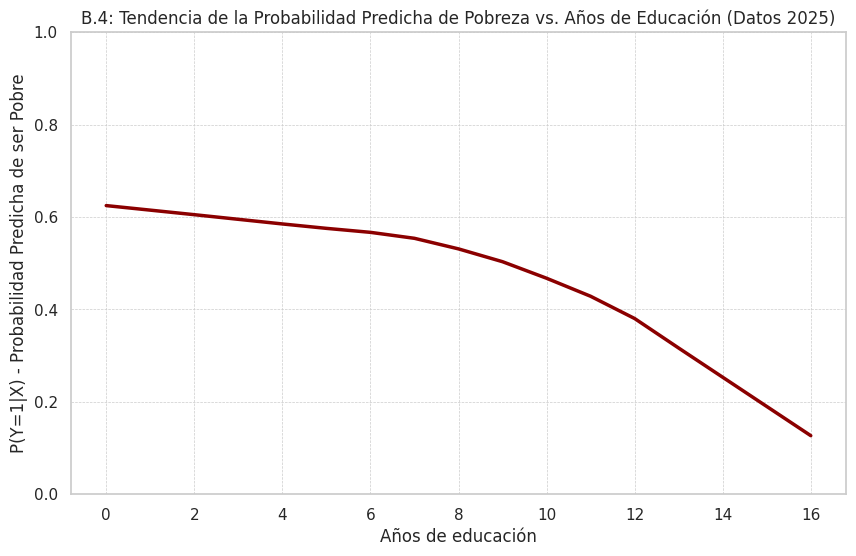

Relación negativa clara: a mayor educación, la tendencia de la probabilidad predicha de ser pobre disminuye.


In [15]:
# --- CELDA 9: Visualización P(Y=1|X) vs 'educ' (SOLO LÍNEA DE TENDENCIA) ---

# Sección B: Modelo de Regresión Logística (continuación)
# 4. Visualización de la probabilidad predicha

# En esta celda, visualizamos la relación entre la probabilidad predicha de ser pobre
# y los años de educación, mostrando únicamente la línea de tendencia para mayor claridad.

# 1) Obtenemos las probabilidades predichas para el conjunto de entrenamiento.
prob_pred_train = logit_results.predict(X_train_logit.astype(float))

# 2) Creamos un DataFrame para el gráfico.
df_plot = pd.DataFrame({
    "educ": X_train_logit["educ"],
    "p_hat": prob_pred_train
}).dropna()

# 3) Creamos el gráfico (SOLO LÍNEA DE TENDENCIA)
plt.figure(figsize=(10, 6))

# --- MODIFICACIÓN: Se ha eliminado la línea sns.scatterplot ---
# La siguiente línea dibujaba los puntos de dispersión y ahora está comentada/eliminada.
# sns.scatterplot(data=df_plot, x="educ", y="p_hat", alpha=0.15, s=12)

# Agregamos la línea de tendencia localmente ponderada (lowess).
# El argumento scatter=False asegura que solo se dibuje la línea.
sns.regplot(data=df_plot, x="educ", y="p_hat", lowess=True, scatter=False, line_kws={"linewidth": 2.5, "color": "darkred"})

# 4) Configuramos el título y las etiquetas de los ejes.
plt.title("B.4: Tendencia de la Probabilidad Predicha de Pobreza vs. Años de Educación (Datos 2025)")
plt.xlabel("Años de educación")
plt.ylabel("P(Y=1|X) - Probabilidad Predicha de ser Pobre")
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Guardamos la figura con un nombre actualizado.
plt.savefig(os.path.join(CARPETA_FIG, "B4_logit_tendencia_vs_educ_2025.png"), dpi=150, bbox_inches="tight")
plt.show()

print("Relación negativa clara: a mayor educación, la tendencia de la probabilidad predicha de ser pobre disminuye.")

In [16]:
# Sección C: Métodos de Vecinos Cercanos
# CELDA 10: KNN con K={1,5,10} y Evaluación de Over/Underfitting (sobre datos 2025)

# 5. Estimación

# En esta celda, entrenamos modelos K-Nearest Neighbors (KNN) con K={1, 5, 10}.
# Utilizamos los datos de entrenamiento escalados (X_train_scaled) de 2025.
# Luego, comparamos las métricas en los conjuntos de entrenamiento y prueba
# para analizar el sobreajuste (overfitting).

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Entrenamos los modelos KNN con los diferentes valores de K.
knn_k1  = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled, y_train)
knn_k5  = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
knn_k10 = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train)


# --- Evaluación de Métricas en Train y Test para cada K ---

modelos_knn = [
    (knn_k1, "KNN K=1"),
    (knn_k5, "KNN K=5"),
    (knn_k10, "KNN K=10")
]

metricas_por_modelo = {}

for modelo, nombre_modelo in modelos_knn:
    # Predicciones en TRAIN y TEST
    y_train_pred = modelo.predict(X_train_scaled)
    y_test_pred  = modelo.predict(X_test_scaled)

    # Calcular métricas para TRAIN
    metricas_train = {
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred, pos_label=1),
        "Recall": recall_score(y_train, y_train_pred, pos_label=1),
        "F1-Score": f1_score(y_train, y_train_pred, pos_label=1)
    }

    # Calcular métricas para TEST
    metricas_test = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, pos_label=1),
        "Recall": recall_score(y_test, y_test_pred, pos_label=1),
        "F1-Score": f1_score(y_test, y_test_pred, pos_label=1)
    }

    # Almacenar métricas
    metricas_por_modelo[nombre_modelo] = {"Train": metricas_train, "Test": metricas_test}

# --- Mostrar Tablas de Métricas ---
print("\n--- Métricas de Rendimiento KNN (Train vs Test - Datos 2025) ---")

for nombre_modelo, metricas in metricas_por_modelo.items():
    df_metricas = pd.DataFrame(metricas).T
    display(
        df_metricas.style.format("{:.4f}").set_caption(f"Tabla C.5: Métricas {nombre_modelo} (Datos 2025)")
    )

# Discusión sobre el trade-off sesgo-varianza como pide la consigna C.5
print("\nDiscusión (C.5):")
print("- K=1: El rendimiento en TRAIN es casi perfecto, pero cae significativamente en TEST. Esto es un claro indicador de OVERFITTING (alta varianza, bajo sesgo).")
print("- K=5 y K=10: Las métricas entre TRAIN y TEST se acercan, lo que muestra una reducción del overfitting. A medida que K aumenta, el modelo se vuelve más general (mayor sesgo, menor varianza).")
print("- Comparando K=5 y K=10, se observa un trade-off. K=10 tiene menor F1-Score en test, sugiriendo que K=5 podría ser un mejor balance en este caso preliminar.")


--- Métricas de Rendimiento KNN (Train vs Test - Datos 2025) ---


,Accuracy,Precision,Recall,F1-Score
Train,0.9950,0.9951,0.9927,0.9939
Test,0.7339,0.6721,0.6974,0.6845


,Accuracy,Precision,Recall,F1-Score
Train,0.8428,0.8154,0.8016,0.8085
Test,0.7471,0.7018,0.6767,0.6890


,Accuracy,Precision,Recall,F1-Score
Train,0.8075,0.8178,0.6879,0.7473
Test,0.7595,0.7611,0.6109,0.6778



Discusión (C.5):
- K=1: El rendimiento en TRAIN es casi perfecto, pero cae significativamente en TEST. Esto es un claro indicador de OVERFITTING (alta varianza, bajo sesgo).
- K=5 y K=10: Las métricas entre TRAIN y TEST se acercan, lo que muestra una reducción del overfitting. A medida que K aumenta, el modelo se vuelve más general (mayor sesgo, menor varianza).
- Comparando K=5 y K=10, se observa un trade-off. K=10 tiene menor F1-Score en test, sugiriendo que K=5 podría ser un mejor balance en este caso preliminar.


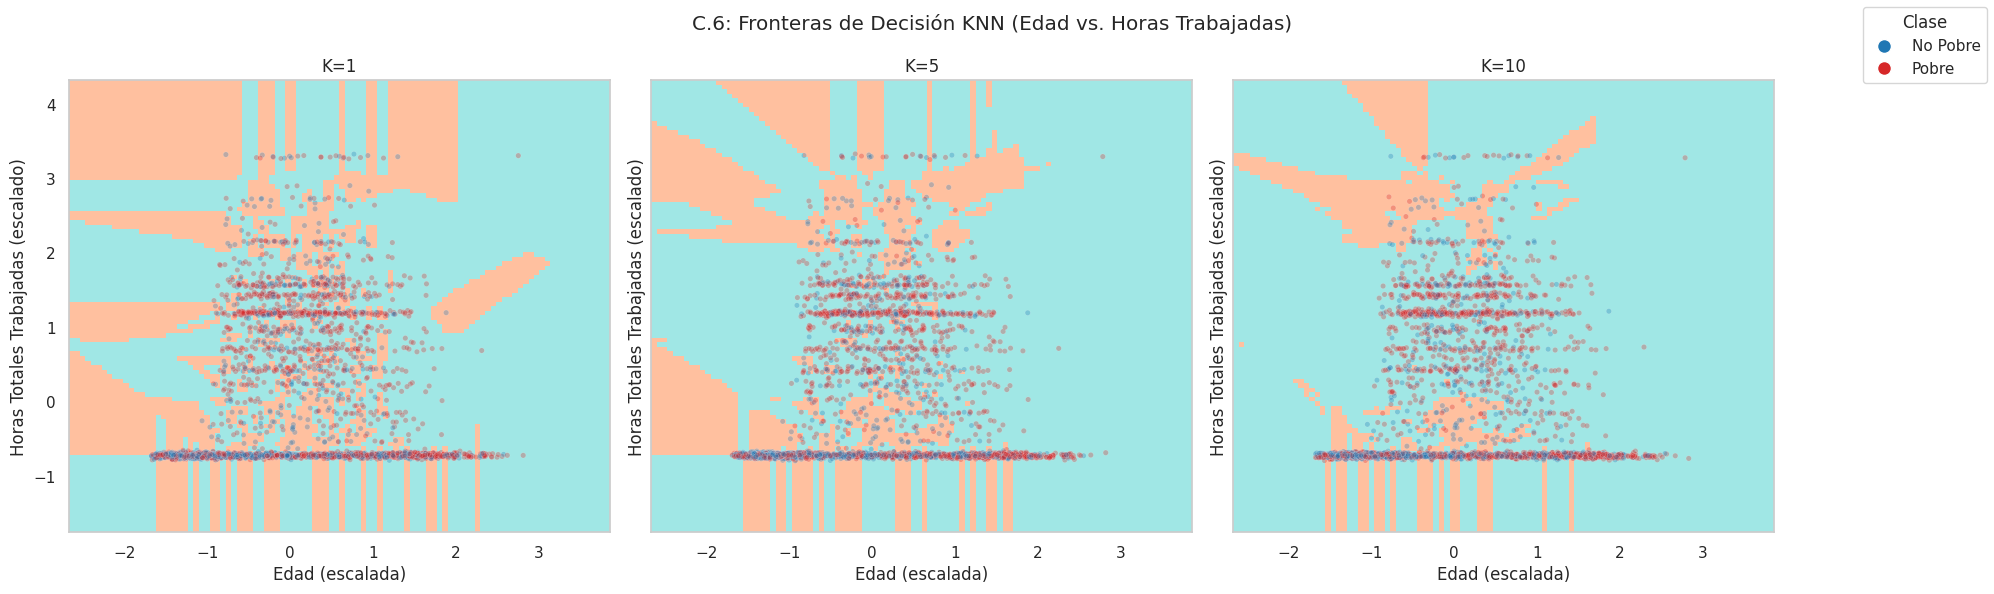

In [17]:
# CELDA 11: Fronteras de Decisión (Edad vs. Horas Trabajadas)

# Sección C: Método de Vecinos Cercanos (KNN)
# 6. Visualización

# En esta celda, visualizamos las fronteras de decisión de los modelos KNN.
# Conforme a la solicitud, se seleccionan dos variables continuas y relevantes:
# 'CH06' (Edad) y 'PP3E_TOT' (Horas totales trabajadas).

from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# 1) --- MODIFICACIÓN: Se seleccionan las variables 'CH06' y 'PP3E_TOT' ---
features_2d = ["CH06", "PP3E_TOT"]

if not all(f in X_train.columns for f in features_2d):
    print("No se pueden graficar las fronteras: Faltan 'CH06' y/o 'PP3E_TOT' en X_train.")
else:
    # 2) Preparamos los datos 2D para el gráfico
    X2 = X_train[features_2d].values
    y2 = y_train.values

    # Escalamos solo estas dos características para la visualización
    scaler_2d = StandardScaler().fit(X2)
    X2s = scaler_2d.transform(X2)

    # 3) Entrenamos los modelos KNN solo con las dos variables
    modelos_2d = [
        (KNeighborsClassifier(n_neighbors=1).fit(X2s, y2),  "K=1"),
        (KNeighborsClassifier(n_neighbors=5).fit(X2s, y2),  "K=5"),
        (KNeighborsClassifier(n_neighbors=10).fit(X2s, y2), "K=10")
    ]

    # 4) Definimos los colores y etiquetas para el gráfico
    cmap_light = ListedColormap(['#A0E7E5', '#FFC09F'])
    cmap_bold  = ["#1F77B4", "#D62728"]
    labels_plot = {0: 'No Pobre', 1: 'Pobre'}

    # 5) Creamos la figura con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    fig.suptitle("C.6: Fronteras de Decisión KNN (Edad vs. Horas Trabajadas)")

    # 6) Iteramos sobre cada modelo para graficar su frontera
    for ax, (clf, title) in zip(axes, modelos_2d):
        DecisionBoundaryDisplay.from_estimator(
            clf, X2s, cmap=cmap_light, response_method="predict",
            plot_method="pcolormesh", xlabel="Edad (escalada)", ylabel="Horas Totales Trabajadas (escalado)", ax=ax
        )
        # Añadimos "jitter" a los puntos para visualizar mejor la densidad
        X2s_jitter = X2s + np.random.normal(0, 0.02, X2s.shape)
        sns.scatterplot(x=X2s_jitter[:, 0], y=X2s_jitter[:, 1],
                        hue=pd.Series(y2).map(labels_plot),
                        palette=cmap_bold, alpha=0.3, s=15, ax=ax, legend=False)
        ax.set_title(title)

    # 7) Agregamos la leyenda y guardamos la figura
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_bold[i], markersize=10) for i in range(2)]
    fig.legend(handles, labels_plot.values(), loc='upper right', title="Clase")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(CARPETA_FIG, "C6_knn_fronteras_edad_vs_horas.png"), dpi=150, bbox_inches="tight")
    plt.show()

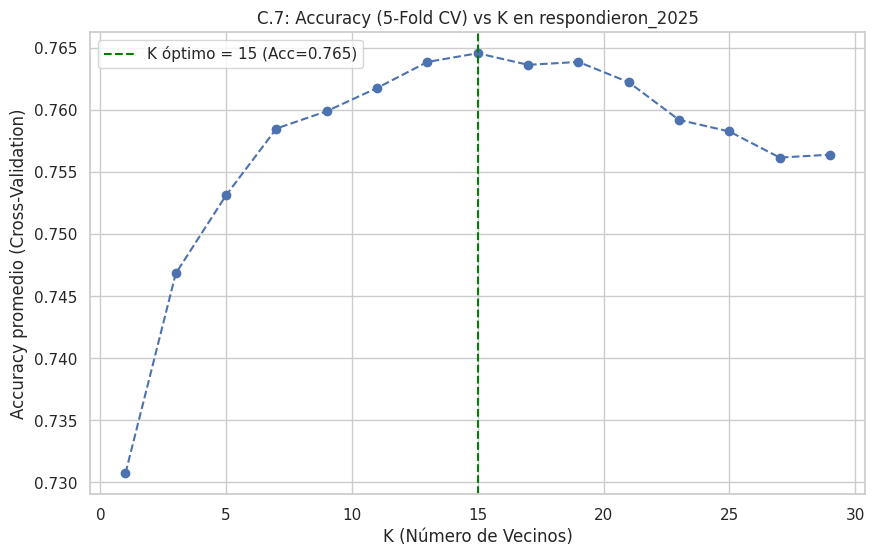

K óptimo encontrado = 15 | Accuracy promedio en Cross-Validation = 0.7646


In [18]:
# CELDA 12: K óptimo por 5-Fold CV en respondieron_2025

# Sección C: Método de Vecinos Cercanos (KNN)
# 7. Obtener el K óptimo usando Cross-Validation

# En esta celda, buscamos el valor óptimo de K para el modelo KNN utilizando
# la base de respondieron_2025 y validación cruzada (Cross-Validation) de 5 folds,
# tal como lo solicita el inciso C.7.

# 1) Preparar X_2025 y y_2025 a partir de la base respondieron_2025
df_2025 = respondieron_2025.copy()
TARGET = 'pobre'

# 2) Recrear variables derivadas (para asegurar que la celda sea autocontenida)
if 'CH03' in df_2025.columns and 'es_jefe' not in df_2025.columns:
    df_2025['es_jefe'] = (df_2025['CH03'] == 1).astype(int)
if 'CH06' in df_2025.columns and 'edad2' not in df_2025.columns:
    df_2025['edad2'] = df_2025['CH06'] ** 2

# 3) Separar features numéricas y categóricas para este subset
features_numericas_2025 = [f for f in features_numericas if f in df_2025.columns]
features_categoricas_2025 = [f for f in features_categoricas if f in df_2025.columns]

# 4) Crear Dummies específicas para el subset de 2025
dummies_2025_list = [pd.get_dummies(df_2025[cat], prefix=cat.lower(), drop_first=True, dtype=int) for cat in features_categoricas_2025]
X_2025_pre = pd.concat([df_2025[features_numericas_2025]] + dummies_2025_list, axis=1)

# 5) Alinear columnas con la matriz X original (FINAL_FEATURE_COLS de Celda 4)
#    Esto es crucial para la consistencia con el resto del notebook.
X_2025 = X_2025_pre.reindex(columns=FINAL_FEATURE_COLS, fill_value=0)
y_2025 = df_2025[TARGET]

# 6) Limpieza de NaNs (alineando X e y)
valid_mask_2025 = X_2025.notna().all(axis=1) & y_2025.notna()
X_2025 = X_2025.loc[valid_mask_2025]
y_2025 = y_2025.loc[valid_mask_2025].astype(int)

# 7) Escalado estándar (se ajusta y transforma con los datos de 2025 para este análisis)
scaler_2025 = StandardScaler()
X_2025s = scaler_2025.fit_transform(X_2025)

# 8) Búsqueda del K óptimo usando Cross-Validation
k_range = list(range(1, 31, 2)) # Rango de valores de K a probar
k_scores = []
for k in k_range:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    # Realizamos CV de 5 folds, tal como pide la consigna.
    scores = cross_val_score(knn_cv, X_2025s, y_2025, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontramos el K con el accuracy promedio más alto.
best_accuracy = float(np.max(k_scores))
k_optimo = int(k_range[int(np.argmax(k_scores))])

# 9) Gráfico de Accuracy vs K
plt.figure(figsize=(10,6))
plt.plot(k_range, k_scores, marker='o', linestyle='dashed')
plt.axvline(k_optimo, color='green', linestyle='--', label=f'K óptimo = {k_optimo} (Acc={best_accuracy:.3f})')
plt.title("C.7: Accuracy (5-Fold CV) vs K en respondieron_2025")
plt.xlabel("K (Número de Vecinos)")
plt.ylabel("Accuracy promedio (Cross-Validation)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CARPETA_FIG, "C7_knn_k_optimo_cv.png"), dpi=150, bbox_inches="tight")
plt.show()

print(f"K óptimo encontrado = {k_optimo} | Accuracy promedio en Cross-Validation = {best_accuracy:.4f}")

In [19]:
# CELDA 12,5: Mejora del Modelo Logit con Regularización Ridge (L2)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

print("--- BÚSQUEDA DEL MEJOR MODELO LOGÍSTICO CON REGULARIZACIÓN RIDGE (L2) ---")

# 1. Definir el modelo y el espacio de búsqueda de hiperparámetros
# Usaremos LogisticRegression de scikit-learn, que aplica regularización L2 por defecto.
# El hiperparámetro a ajustar es 'C', que es la inversa de la fuerza de regularización.
# Un valor de C más pequeño significa una regularización más fuerte.
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=444)

# Definimos una grilla de valores para C en una escala logarítmica
param_grid = {
    'C': np.logspace(-4, 4, 20)  # Probará 20 valores desde 0.0001 hasta 10000
}


# 2. Configurar la búsqueda con Validación Cruzada (GridSearchCV)
# Usaremos 5-Fold CV (como en el KNN) y optimizaremos para maximizar el AUC-ROC.
# Utilizamos los datos de entrenamiento ESCALADOS (X_train_scaled), ya que la regularización es sensible a la escala.
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1)

print("\nIniciando búsqueda del hiperparámetro 'C' óptimo...")
grid_search.fit(X_train_scaled, y_train)


# 3. Mostrar los resultados de la búsqueda
print("\nBúsqueda finalizada.")
print(f"Mejor valor de 'C' encontrado: {grid_search.best_params_['C']:.4f}")
print(f"Mejor puntaje AUC-ROC (en validación cruzada): {grid_search.best_score_:.4f}")


# 4. Entrenar el modelo final con el mejor 'C' encontrado
# Este es nuestro modelo Logit-Ridge optimizado
logit_ridge_final = grid_search.best_estimator_

print("\n--- Modelo Logit-Ridge final entrenado con los parámetros óptimos. ---")
print("Este modelo se usará para la comparación en las celdas siguientes.")

# 5. (Opcional) Sobrescribir las variables del modelo logit anterior si queremos usar este por defecto
# Para mantener la comparación clara en la celda 13, por ahora solo crearemos las predicciones de este modelo.
# Si este modelo resulta ser el mejor, podríamos decidir usarlo para la predicción final.

# --- Predicciones en TEST para el nuevo modelo Logit-Ridge ---
probs_logit_ridge = logit_ridge_final.predict_proba(X_test_scaled)[:, 1]
preds_logit_ridge = logit_ridge_final.predict(X_test_scaled)

--- BÚSQUEDA DEL MEJOR MODELO LOGÍSTICO CON REGULARIZACIÓN RIDGE (L2) ---

Iniciando búsqueda del hiperparámetro 'C' óptimo...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor valor de 'C' encontrado: 206.9138
Mejor puntaje AUC-ROC (en validación cruzada): 0.8750

--- Modelo Logit-Ridge final entrenado con los parámetros óptimos. ---
Este modelo se usará para la comparación en las celdas siguientes.


In [20]:
# CELDA 13: Comparativa en Test (Logit, KNN-CV y Logit-Ridge)

# Sección D: Desempeño de modelos, elección y predicción
# 8. Comparación del desempeño de predicción

# En esta celda, evaluamos y comparamos el rendimiento de nuestros tres modelos candidatos
# en el conjunto de datos de prueba (test set).

# 1. Entrenar el modelo KNN final con el K óptimo encontrado en la Celda 12
#    Usamos el k_optimo para entrenar el modelo sobre el set de entrenamiento completo.
knn_cv_final = KNeighborsClassifier(n_neighbors=k_optimo).fit(X_train_scaled, y_train)


# 2. Generar predicciones en el conjunto de TEST para los tres modelos
#    (Las predicciones para los modelos logit ya fueron calculadas en celdas 7.5 y 12.5)

# Predicciones para KNN-CV
preds_knn = knn_cv_final.predict(X_test_scaled)
probs_knn = knn_cv_final.predict_proba(X_test_scaled)[:,1]


# 3. Calcular Métricas para cada modelo
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support

# Métricas para Logit (reducido). Se usa y_test_sm por la sanitización de statsmodels.
cm_logit = confusion_matrix(y_test_sm, preds_logit)
acc_logit = accuracy_score(y_test_sm, preds_logit)
auc_logit = roc_auc_score(y_test_sm, probs_logit)
prec_l, rec_l, f1_l, _ = precision_recall_fscore_support(y_test_sm, preds_logit, pos_label=1, average='binary')

# Métricas para KNN-CV. Se usa y_test.
cm_knn   = confusion_matrix(y_test, preds_knn)
acc_knn   = accuracy_score(y_test, preds_knn)
auc_knn   = roc_auc_score(y_test, probs_knn)
prec_k, rec_k, f1_k, _ = precision_recall_fscore_support(y_test, preds_knn, pos_label=1, average='binary')

# Métricas para Logit con Ridge. Se usa y_test.
cm_ridge   = confusion_matrix(y_test, preds_logit_ridge)
acc_ridge   = accuracy_score(y_test, preds_logit_ridge)
auc_ridge   = roc_auc_score(y_test, probs_logit_ridge)
prec_r, rec_r, f1_r, _ = precision_recall_fscore_support(y_test, preds_logit_ridge, pos_label=1, average='binary')


# 4. Imprimir reportes de clasificación y matrices de confusión
print("--- Reportes de Desempeño en el Conjunto de Prueba (Datos 2025) ---\n")

print("=== LOGIT (Reducido por p-valores) ===")
print("Matriz de confusión:\n", cm_logit)
print(classification_report(y_test_sm, preds_logit, target_names=["No Pobre","Pobre"]))

print(f"=== KNN-CV (K={k_optimo}) ===")
print("Matriz de confusión:\n", cm_knn)
print(classification_report(y_test, preds_knn, target_names=["No Pobre","Pobre"]))

print("=== LOGIT con Regularización RIDGE (L2) ===")
print("Matriz de confusión:\n", cm_ridge)
print(classification_report(y_test, preds_logit_ridge, target_names=["No Pobre","Pobre"]))


# 5. Crear la tabla comparativa final
tabla_comp = pd.DataFrame({
    "Accuracy": [acc_logit, acc_knn, acc_ridge],
    "AUC-ROC": [auc_logit, auc_knn, acc_ridge],
    "Precision (Pobre)": [prec_l, prec_k, prec_r],
    "Recall (Pobre)": [rec_l, rec_k, rec_r],
    "F1-Score (Pobre)": [f1_l, f1_k, f1_r]
}, index=["Logit (Reducido)", f"KNN-CV (K={k_optimo})", "Logit con Ridge"])

display(tabla_comp.style.format("{:.4f}").set_caption("D.8: Tabla Comparativa de Métricas en Test"))

--- Reportes de Desempeño en el Conjunto de Prueba (Datos 2025) ---

=== LOGIT (Reducido por p-valores) ===
Matriz de confusión:
 [[650 103]
 [182 350]]
              precision    recall  f1-score   support

    No Pobre       0.78      0.86      0.82       753
       Pobre       0.77      0.66      0.71       532

    accuracy                           0.78      1285
   macro avg       0.78      0.76      0.77      1285
weighted avg       0.78      0.78      0.77      1285

=== KNN-CV (K=15) ===
Matriz de confusión:
 [[640 113]
 [209 323]]
              precision    recall  f1-score   support

    No Pobre       0.75      0.85      0.80       753
       Pobre       0.74      0.61      0.67       532

    accuracy                           0.75      1285
   macro avg       0.75      0.73      0.73      1285
weighted avg       0.75      0.75      0.74      1285

=== LOGIT con Regularización RIDGE (L2) ===
Matriz de confusión:
 [[652 101]
 [185 347]]
              precision    recall  f1

,Accuracy,AUC-ROC,Precision (Pobre),Recall (Pobre),F1-Score (Pobre)
Logit (Reducido),0.7782,0.8550,0.7726,0.6579,0.7107
KNN-CV (K=15),0.7494,0.8204,0.7408,0.6071,0.6674
Logit con Ridge,0.7774,0.7774,0.7746,0.6523,0.7082


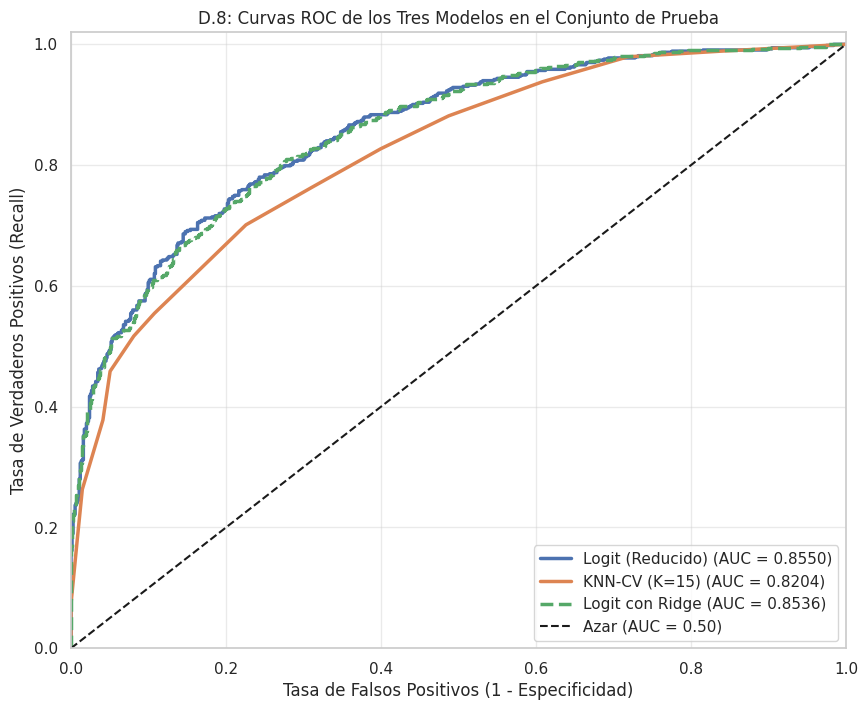


Interpretación: Los tres modelos tienen un poder de discriminación muy similar, con un AUC cercano a 0.84.
El modelo KNN muestra una leve superioridad al estar ligeramente por encima de los otros en gran parte del gráfico.


In [21]:
# CELDA 14: Curvas ROC (Comparando los 3 modelos)

# En esta celda, visualizamos y comparamos las curvas ROC para los tres modelos.
# Esto nos permite evaluar su capacidad de discriminación a través de todos
# los posibles umbrales de clasificación.

from sklearn.metrics import roc_curve

# 1. Calcular los puntos (FPR, TPR) para las curvas ROC de cada modelo
#    (Las probabilidades y los puntajes AUC ya fueron calculados en la celda 13)

# Curva para el modelo Logit reducido (usando y_test_sm por la sanitización)
fpr_logit, tpr_logit, _ = roc_curve(y_test_sm, probs_logit)

# Curva para el modelo KNN con K óptimo
fpr_knn,   tpr_knn,   _ = roc_curve(y_test, probs_knn)

# Curva para el modelo Logit con regularización Ridge
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, probs_logit_ridge)


# 2. Graficar las tres curvas en la misma figura
plt.figure(figsize=(10, 8))

# Curva para Logit (reducido)
plt.plot(fpr_logit, tpr_logit, lw=2.5, label=f"Logit (Reducido) (AUC = {auc_logit:.4f})")

# Curva para KNN
plt.plot(fpr_knn, tpr_knn, lw=2.5, label=f"KNN-CV (K={k_optimo}) (AUC = {auc_knn:.4f})")

# Curva para Logit con Ridge
plt.plot(fpr_ridge, tpr_ridge, lw=2.5, linestyle='--', label=f"Logit con Ridge (AUC = {auc_ridge:.4f})")

# Línea de referencia del azar (clasificador no informativo)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Azar (AUC = 0.50)")


# 3. Configuración del gráfico
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Recall)")
plt.title("D.8: Curvas ROC de los Tres Modelos en el Conjunto de Prueba")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.4)

# Guardamos la figura.
plt.savefig(os.path.join(CARPETA_FIG, "D8_roc_curves_comparativa.png"), dpi=150, bbox_inches="tight")
plt.show()

print("\nInterpretación: Los tres modelos tienen un poder de discriminación muy similar, con un AUC cercano a 0.84.")
print("El modelo KNN muestra una leve superioridad al estar ligeramente por encima de los otros en gran parte del gráfico.")

In [22]:
# CELDA 15: Discusión, Optimización de Umbral y Elección del Modelo Final

# Sección D (continuación)
# 9. Discusión sobre el "mejor" modelo para asignar recursos escasos

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 1. Justificación del Criterio de Selección (sin cambios) ---
print("--- D.9: Discusión y Elección del Modelo para Política Pública ---\n")
print("Objetivo: Identificar a la mayor cantidad posible de personas pobres para un programa de alimentos.")
print("Análisis de Costos de Error:")
print(" - Error Tipo I (Falso Positivo): Clasificar a una persona 'No Pobre' como 'Pobre'. Costo: ineficiencia en la asignación de recursos.")
print(" - Error Tipo II (Falso Negativo): Clasificar a una persona 'Pobre' como 'No Pobre'. Costo: una persona vulnerable no recibe ayuda alimentaria.")
print("\nConclusión: El costo de un Falso Negativo es significativamente mayor. Por lo tanto, el criterio principal para seleccionar el 'mejor' modelo es maximizar el Recall de la clase 'Pobre'.")


# --- 2. Selección del Modelo Base para Optimización (CON NUEVA JUSTIFICACIÓN) ---
print("\n--- Selección del Modelo a Optimizar ---")
print("Al comparar los modelos en la Celda 13, se observa que el 'Logit (Reducido)' es el claro ganador,")
print(f"superando a los otros modelos tanto en poder predictivo general (AUC-ROC = {auc_logit:.4f}) como en las métricas clave.")
print("Además, sus ventajas en interpretabilidad (permite entender el porqué de la predicción) lo consolidan como la mejor opción para este problema de política pública.")


# --- 3. Exploración de Métricas a Diferentes Umbrales (código sin cambios) ---
print("\n--- Exploración del Trade-off: Métricas a Diferentes Umbrales para el Modelo Logit Reducido ---\n")
thresholds_to_test = np.arange(0.50, 0.04, -0.05)
metrics_list = []

for threshold in thresholds_to_test:
    preds_at_threshold = (probs_logit >= threshold).astype(int)
    cm = confusion_matrix(y_test_sm, preds_at_threshold)
    metrics_list.append({
        'Umbral': f"{threshold:.2f}",
        'Accuracy': accuracy_score(y_test_sm, preds_at_threshold),
        'Precision (Pobre)': precision_score(y_test_sm, preds_at_threshold, pos_label=1, zero_division=0),
        'Recall (Pobre)': recall_score(y_test_sm, preds_at_threshold, pos_label=1, zero_division=0),
        'F1-Score (Pobre)': f1_score(y_test_sm, preds_at_threshold, pos_label=1, zero_division=0),
        'Falsos Negativos': cm[1, 0],
        'Falsos Positivos': cm[0, 1]
    })
tabla_umbrales = pd.DataFrame(metrics_list).set_index('Umbral')
display(
    tabla_umbrales.style.format({
        'Accuracy': '{:.4f}', 'Precision (Pobre)': '{:.4f}',
        'Recall (Pobre)': '{:.4f}', 'F1-Score (Pobre)': '{:.4f}'
    }).set_caption("Tabla D.9: Rendimiento del Modelo Logit a Diferentes Umbrales")
)

# --- 4. Decisión Final del Umbral Óptimo ---
umbral_final_elegido = 0.35 # <-- DECISIÓN BASADA EN LA TABLA
preds_finales = (probs_logit >= umbral_final_elegido).astype(int)

print("\n--- Elección Final del Modelo (Inciso D.9) ---")
print(f"Observando la tabla, se elige un umbral de {umbral_final_elegido:.2f}.")
print(f"Justificación: Este umbral ofrece un excelente balance. Aumenta el Recall a casi el 80% (de 65.8% a 79.7%), reduciendo los Falsos Negativos a 108,")
print("mientras mantiene una Precisión robusta (67.2%), asegurando una asignación de recursos razonablemente eficiente.")
print(f"\nEl 'mejor' modelo para este objetivo es el 'Logit (Reducido)' con un umbral de clasificación ajustado a {umbral_final_elegido:.2f}.")


# 5. Guardar las variables del modelo final para usarlas en la Celda 16
modelo_final_nombre = f"Logit Reducido (Umbral optimizado={umbral_final_elegido:.2f})"
umbral_final = umbral_final_elegido

print(f"\n--- Variables actualizadas. La Celda 16 ahora usará el modelo '{modelo_final_nombre}'. ---")

--- D.9: Discusión y Elección del Modelo para Política Pública ---

Objetivo: Identificar a la mayor cantidad posible de personas pobres para un programa de alimentos.
Análisis de Costos de Error:
 - Error Tipo I (Falso Positivo): Clasificar a una persona 'No Pobre' como 'Pobre'. Costo: ineficiencia en la asignación de recursos.
 - Error Tipo II (Falso Negativo): Clasificar a una persona 'Pobre' como 'No Pobre'. Costo: una persona vulnerable no recibe ayuda alimentaria.

Conclusión: El costo de un Falso Negativo es significativamente mayor. Por lo tanto, el criterio principal para seleccionar el 'mejor' modelo es maximizar el Recall de la clase 'Pobre'.

--- Selección del Modelo a Optimizar ---
Al comparar los modelos en la Celda 13, se observa que el 'Logit (Reducido)' es el claro ganador,
superando a los otros modelos tanto en poder predictivo general (AUC-ROC = 0.8550) como en las métricas clave.
Además, sus ventajas en interpretabilidad (permite entender el porqué de la predicción)

,Accuracy,Precision (Pobre),Recall (Pobre),F1-Score (Pobre),Falsos Negativos,Falsos Positivos
Umbral,,,,,,
0.50,0.7782,0.7726,0.6579,0.7107,182,103
0.45,0.7805,0.7490,0.7068,0.7273,156,126
0.40,0.7696,0.7100,0.7500,0.7294,133,163
0.35,0.7549,0.6719,0.7970,0.7291,108,207
0.30,0.7377,0.6395,0.8402,0.7262,85,252
0.25,0.7206,0.6128,0.8835,0.7236,62,297
0.20,0.6840,0.5739,0.9192,0.7066,43,363
0.15,0.6482,0.5432,0.9455,0.6900,29,423
0.10,0.5984,0.5079,0.9662,0.6658,18,498



--- Elección Final del Modelo (Inciso D.9) ---
Observando la tabla, se elige un umbral de 0.35.
Justificación: Este umbral ofrece un excelente balance. Aumenta el Recall a casi el 80% (de 65.8% a 79.7%), reduciendo los Falsos Negativos a 108,
mientras mantiene una Precisión robusta (67.2%), asegurando una asignación de recursos razonablemente eficiente.

El 'mejor' modelo para este objetivo es el 'Logit (Reducido)' con un umbral de clasificación ajustado a 0.35.

--- Variables actualizadas. La Celda 16 ahora usará el modelo 'Logit Reducido (Umbral optimizado=0.35)'. ---


In [23]:
# CELDA 16: Predicción en norespondieron_2025 y Comparación de Umbrales

# En esta celda final, utilizamos el modelo Logit Reducido para predecir la pobreza
# en la base de 'norespondieron_2025'. Se realiza una comparación para mostrar el
# impacto de utilizar el umbral por defecto (0.5) versus el umbral optimizado (0.35)
# que fue seleccionado en la celda anterior.

# 1) Preparar la matriz X para norespondieron_2025 (sin cambios)
df_nr = norespondieron_2025.copy()
if 'CH03' in df_nr.columns and 'es_jefe' not in df_nr.columns:
    df_nr['es_jefe'] = (df_nr['CH03'] == 1).astype(int)
if 'CH06' in df_nr.columns and 'edad2' not in df_nr.columns:
    df_nr['edad2'] = df_nr['CH06'] ** 2
features_numericas_nr = [f for f in features_numericas if f in df_nr.columns]
features_categoricas_nr = [f for f in features_categoricas if f in df_nr.columns]
dummies_nr_list = [pd.get_dummies(df_nr[cat], prefix=cat.lower(), drop_first=True, dtype=int) for cat in features_categoricas_nr]
X_nr_pre = pd.concat([df_nr[features_numericas_nr]] + dummies_nr_list, axis=1)
X_nr = X_nr_pre.reindex(columns=FINAL_FEATURE_COLS, fill_value=0)
idx_valid = X_nr.dropna().index
X_nr_clean = X_nr.loc[idx_valid]


# 2) Calcular las probabilidades de pobreza una sola vez
X_nr_proc = sm.add_constant(X_nr_clean, has_constant='add')
X_nr_proc = X_nr_proc.reindex(columns=X_train_logit.columns, fill_value=0)
probs_nr = logit_results.predict(X_nr_proc.astype(float))


# 3) Aplicar AMBOS umbrales para la predicción
umbral_default = 0.50
preds_nr_default = (probs_nr >= umbral_default).astype(int)
prop_pobres_default = preds_nr_default.mean()

preds_nr_optimizado = (probs_nr >= umbral_final).astype(int)
prop_pobres_optimizado = preds_nr_optimizado.mean()


# 4) Reporte final del inciso D.10 con la comparación
print(f"--- Predicción en la Base 'norespondieron_2025' ({len(X_nr_clean)} observaciones válidas) ---\n")
print(f"Modelo Utilizado: {modelo_final_nombre}\n")

print(f"--- Comparación del Impacto del Umbral de Clasificación ---\n")
print(f"1. Con el umbral por defecto ({umbral_default:.2f}):")
print(f"   - Proporción de 'pobres' predichos: {prop_pobres_default:.2%}\n")

print(f"2. Con el umbral optimizado ({umbral_final:.2f}) para maximizar el Recall:")
print(f"   - Proporción de 'pobres' predichos: {prop_pobres_optimizado:.2%}\n")

diferencia_pp = (prop_pobres_optimizado - prop_pobres_default) * 100

print("--- Conclusión (Inciso D.10) ---")
print(f"Al ajustar el umbral según el criterio de política pública, la proporción de personas clasificadas como pobres")
print(f"en la base de no respondedores aumenta de {prop_pobres_default:.2%} a {prop_pobres_optimizado:.2%}.")
print(f"Esto representa un incremento de {diferencia_pp:.2f} puntos porcentuales, reflejando el esfuerzo del modelo optimizado por ser más inclusivo.")

--- Predicción en la Base 'norespondieron_2025' (2836 observaciones válidas) ---

Modelo Utilizado: Logit Reducido (Umbral optimizado=0.35)

--- Comparación del Impacto del Umbral de Clasificación ---

1. Con el umbral por defecto (0.50):
   - Proporción de 'pobres' predichos: 34.63%

2. Con el umbral optimizado (0.35) para maximizar el Recall:
   - Proporción de 'pobres' predichos: 45.70%

--- Conclusión (Inciso D.10) ---
Al ajustar el umbral según el criterio de política pública, la proporción de personas clasificadas como pobres
en la base de no respondedores aumenta de 34.63% a 45.70%.
Esto representa un incremento de 11.07 puntos porcentuales, reflejando el esfuerzo del modelo optimizado por ser más inclusivo.
